In [187]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
pd.options.mode.chained_assignment = None  # default='warn'

In [188]:
label_regular = 'Gasolina regular'
label_super = 'Gasolina superior'
label_diesel = 'Diesel'

# Exploración de Datos

In [189]:
dfToUse = "consumo"

def returnQuantRows(dfToUse):
    if (dfToUse == 'consumo'):
        return 269 
    return 257

toUse = returnQuantRows(dfToUse)

In [190]:
df = pd.read_excel(dfToUse+'.xlsx', engine='openpyxl')
df = df[['Fecha', label_super, label_regular, label_diesel]]

In [191]:
df = df[:toUse]
df['Fecha'] = pd.to_datetime(df['Fecha'])

In [193]:
quant_vars = [label_super, label_regular, label_diesel]
df[quant_vars].astype(float).describe()

Gasolina superior  Gasolina regular        Diesel
count         269.000000        269.000000  2.690000e+02
mean       451431.636263     348337.277960  8.390665e+05
std        102271.841049     172663.330234  1.965830e+05
min        300242.781667     160741.900000  5.076627e+05
25%        380800.430000     212696.380000  6.881041e+05
50%        411088.530000     268917.790000  7.936940e+05
75%        545210.000000     476277.640000  9.687487e+05
max        768102.830000     821882.150000  1.427888e+06

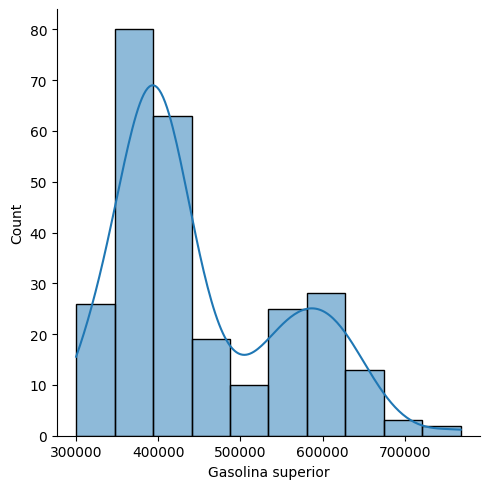

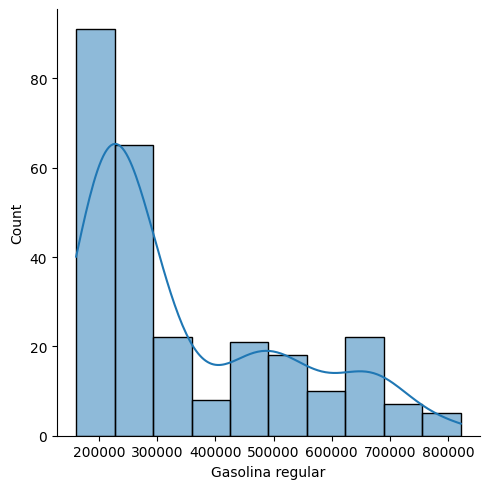

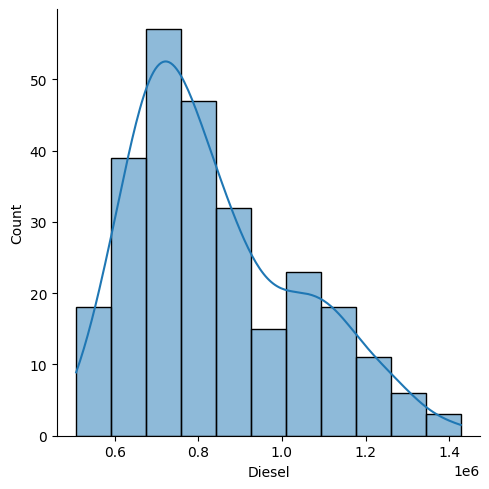

In [194]:
for var in quant_vars:
    data = df[var].dropna(how='all', axis=0)
    
    # Gráfico
    sns.displot(data, kde=True)
    # print('\033[1m' + var + '\033[0m' + ': Kurtosis:', stats.kurtosis(data), 'Skewness:', stats.skew(data), '\n')


# Por año

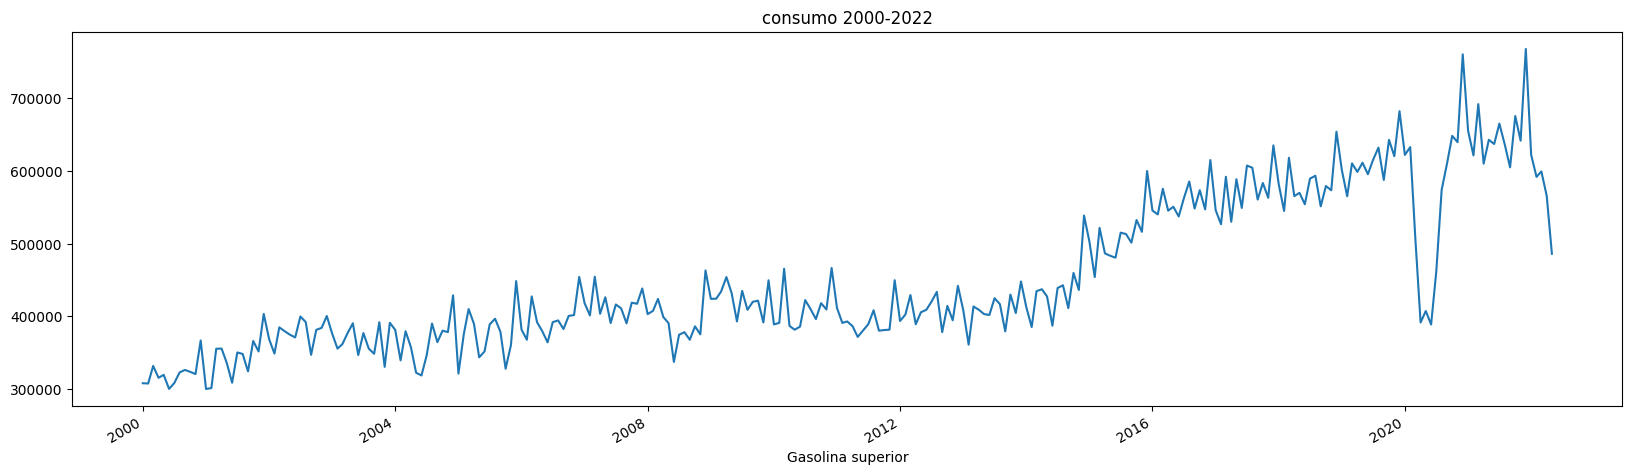

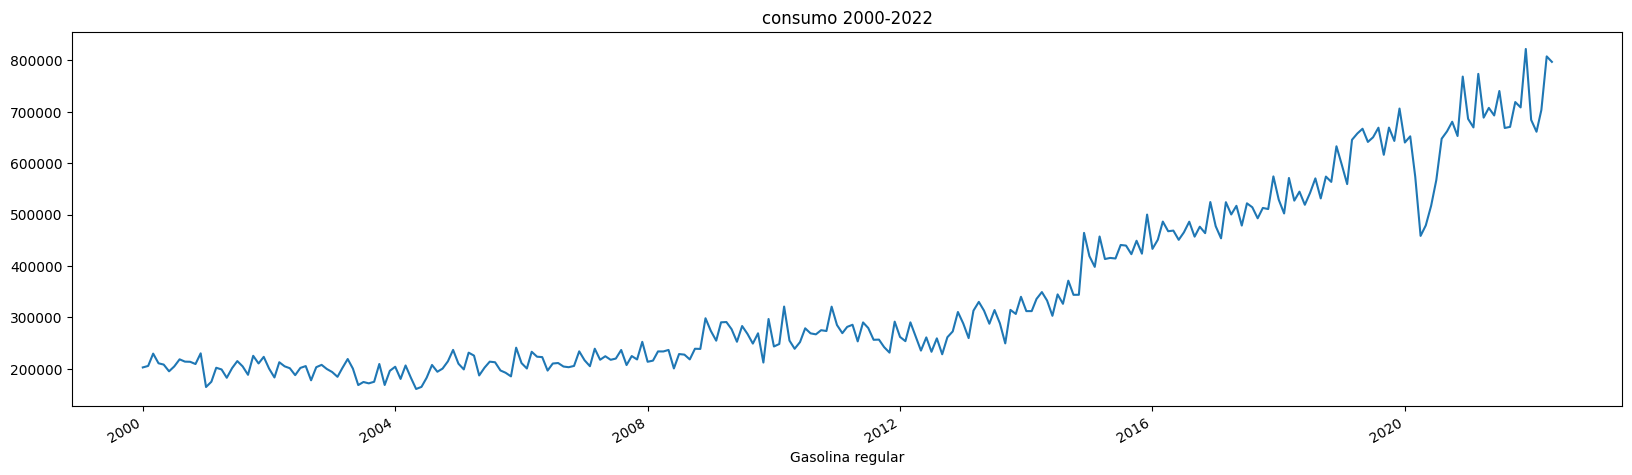

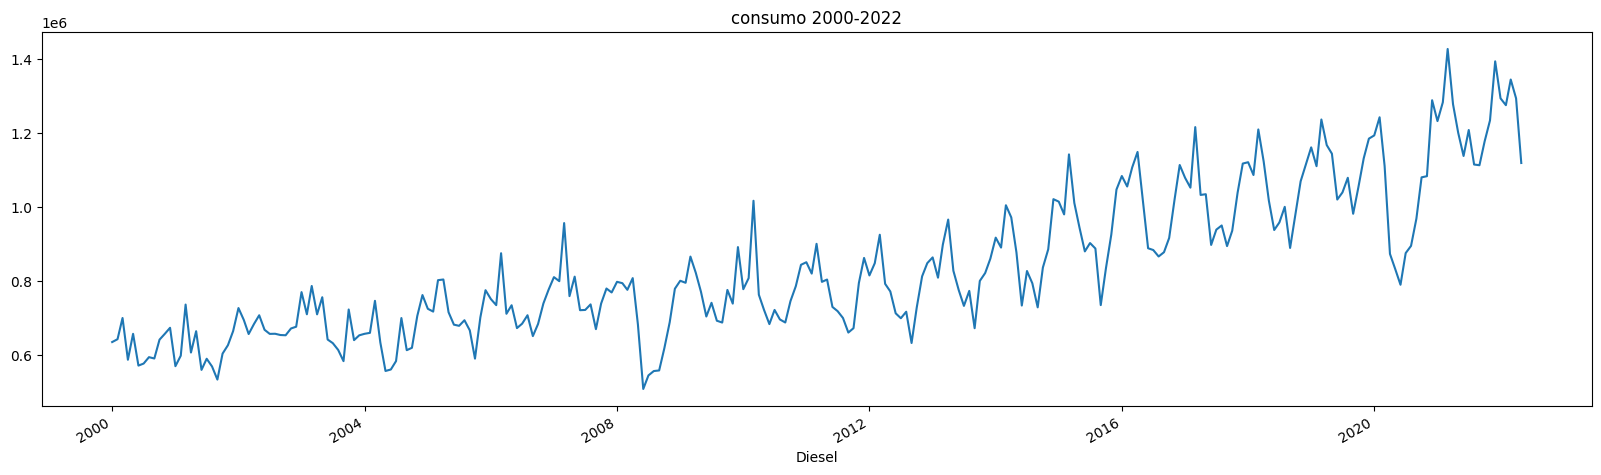

In [195]:
plt.rcParams["figure.figsize"] = (20,5.5)

for gas in quant_vars:
    x = df['Fecha']
    y = df[gas]

    plt.title(dfToUse+" 2000-2022")
    # beautify the x-labels
    plt.gcf().autofmt_xdate()
    plt.xlabel(gas)


    plt.plot(x, y)
    plt.show()

# Por mes

In [196]:
dfPerMonth = df.groupby(df['Fecha'].dt.month)
dfPerMonth = dfPerMonth.sum()

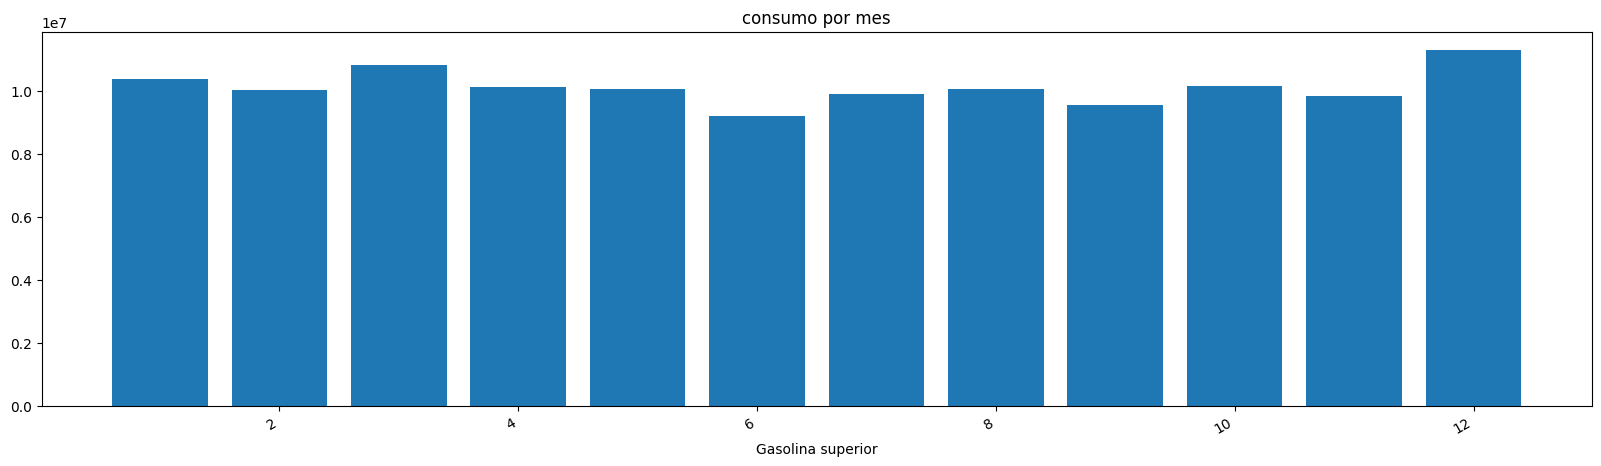

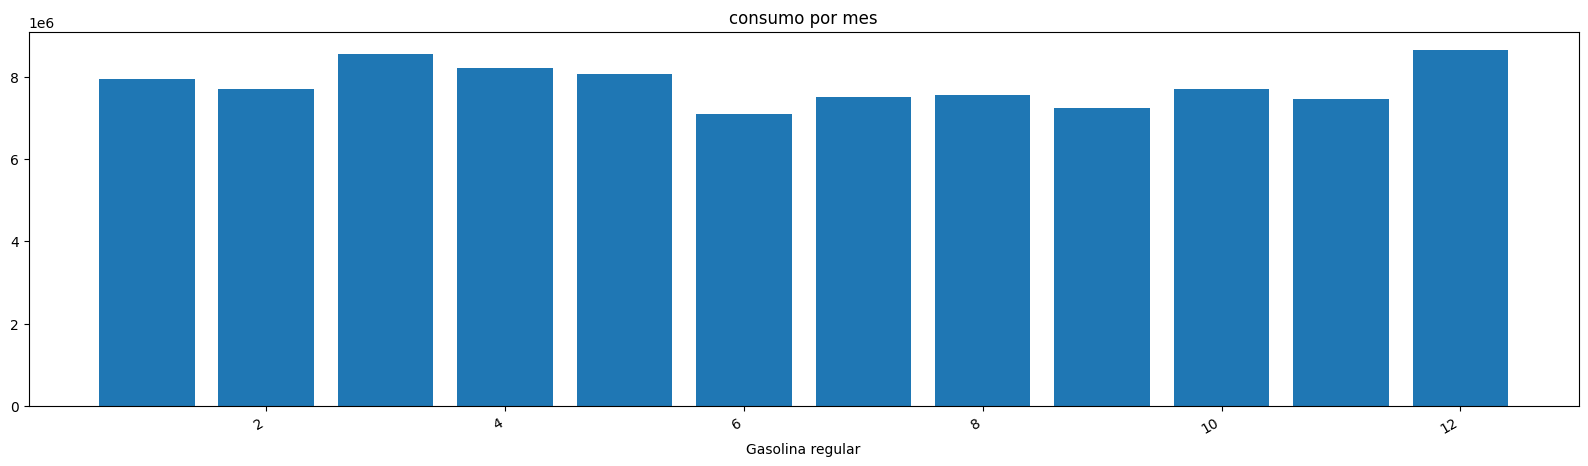

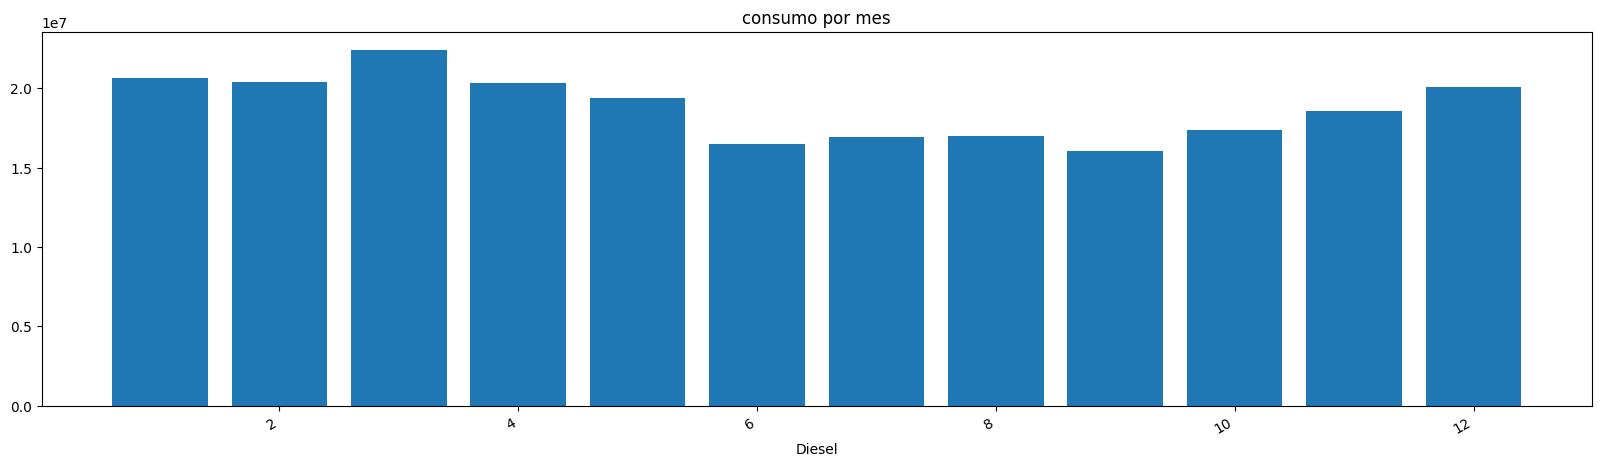

In [197]:
plt.rcParams["figure.figsize"] = (20,5.5)

for gas in quant_vars:
    x = dfPerMonth.index
    y = dfPerMonth[gas]


    plt.title(dfToUse+" por mes")
    # beautify the x-labels
    plt.gcf().autofmt_xdate()
    plt.xlabel(gas)


    plt.bar(x, y)
    plt.show()

# Comportamiento en la pandemia

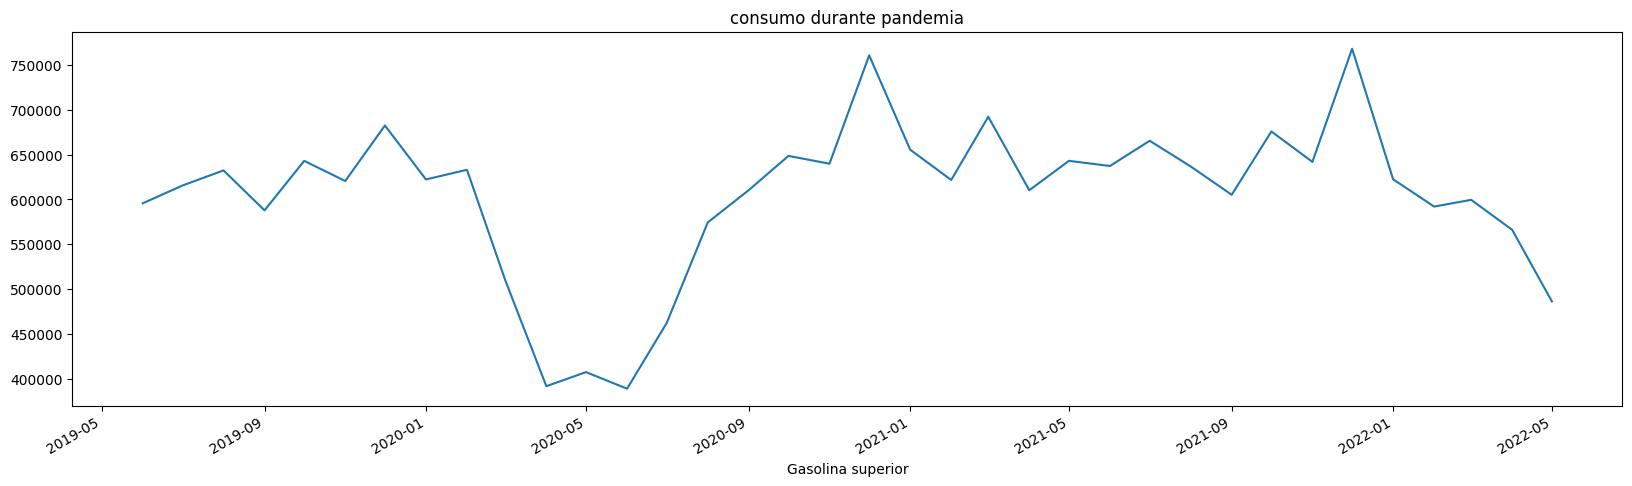

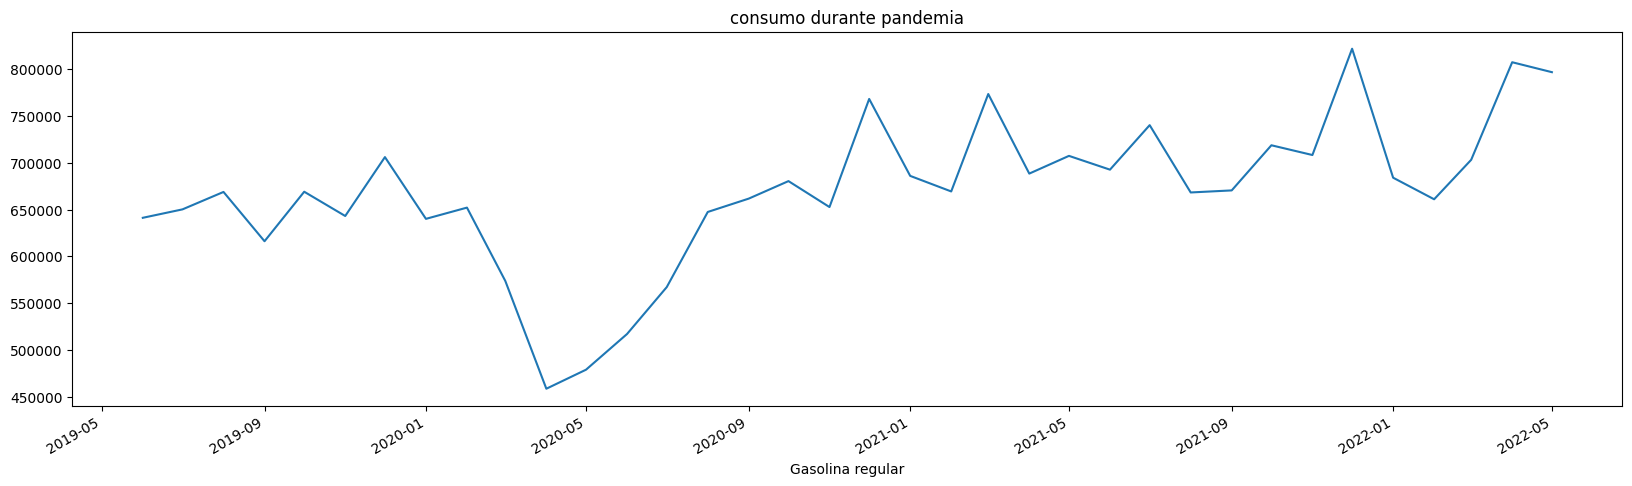

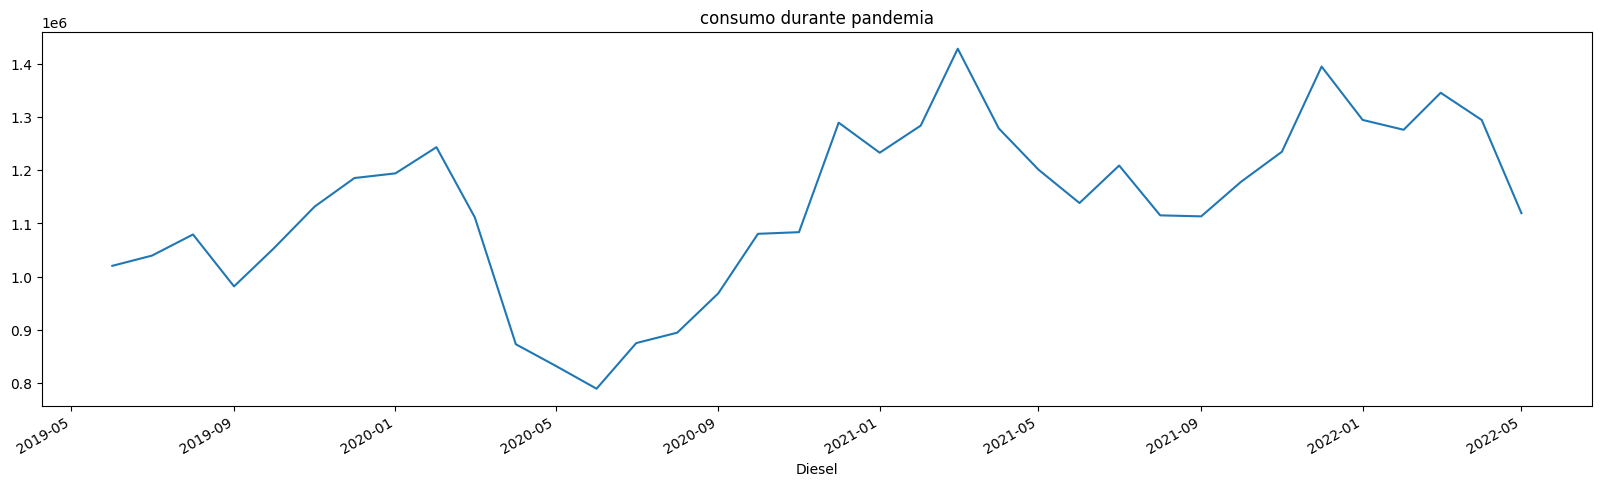

In [198]:
plt.rcParams["figure.figsize"] = (20,5.5)
quant_to_have = 12

for gas in quant_vars:
    x = df['Fecha'].tail(quant_to_have * 3)
    y = df[gas].tail(quant_to_have * 3)

    plt.title(dfToUse+" durante pandemia")
    # beautify the x-labels
    plt.gcf().autofmt_xdate()
    plt.xlabel(gas)


    plt.plot(x, y)
    plt.show()

# Separando test y train

In [199]:
rows = len(df)
train_df = df[0:rows-17]
test_df = df[rows-17:]
print(len(train_df), len(test_df))

252 17


## Pasos para construir modelos ARIMA
1. Identificación
2. Estimación
3. Validación
4. Predicción

In [202]:
def make_timeline(column):
  plt.rcParams["figure.figsize"] = (20,5.5)
  mediaGasoline = train_df[column].rolling(window=12).mean()
  deGasoline = train_df[column].rolling(window=12).std()

  original = plt.plot(train_df[column], color="blue", label="Original")
  media = plt.plot(mediaGasoline, color='red', label = 'Media ' + dfToUse)
  ds = plt.plot(deGasoline, color='black', label = 'Desviación Estándar ' + dfToUse)
  plt.legend(loc = 'best')
  plt.title('Media y desviación estándar ' + column)
  plt.show(block=False)

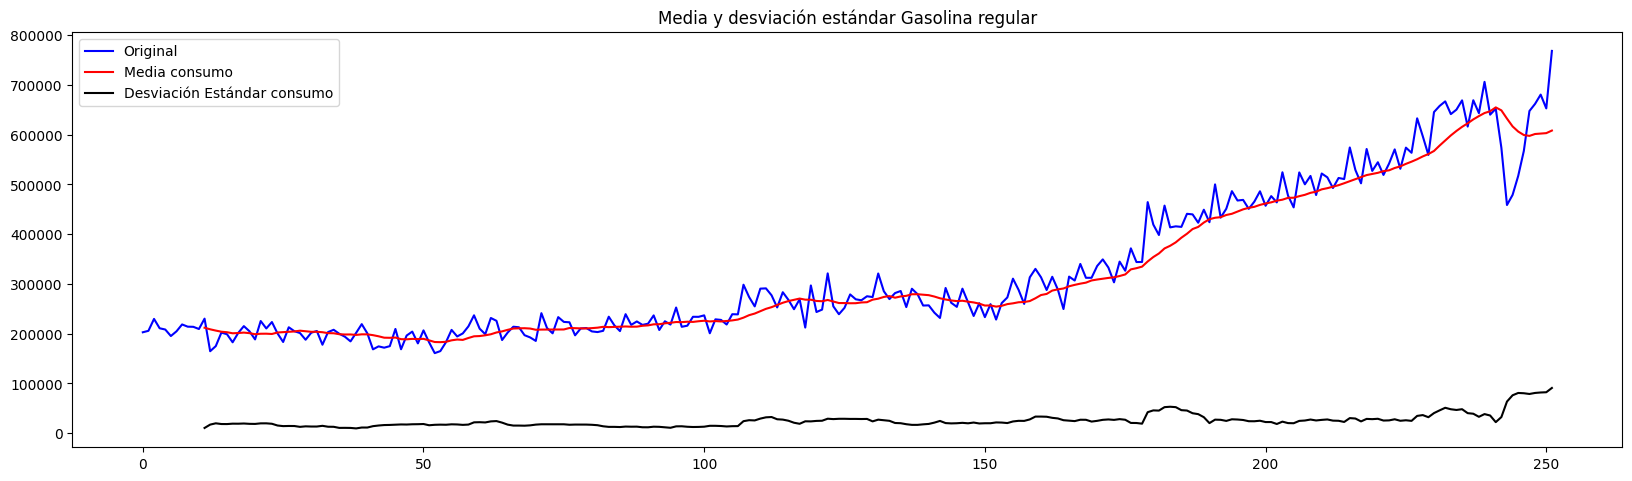

In [203]:
make_timeline(label_regular)

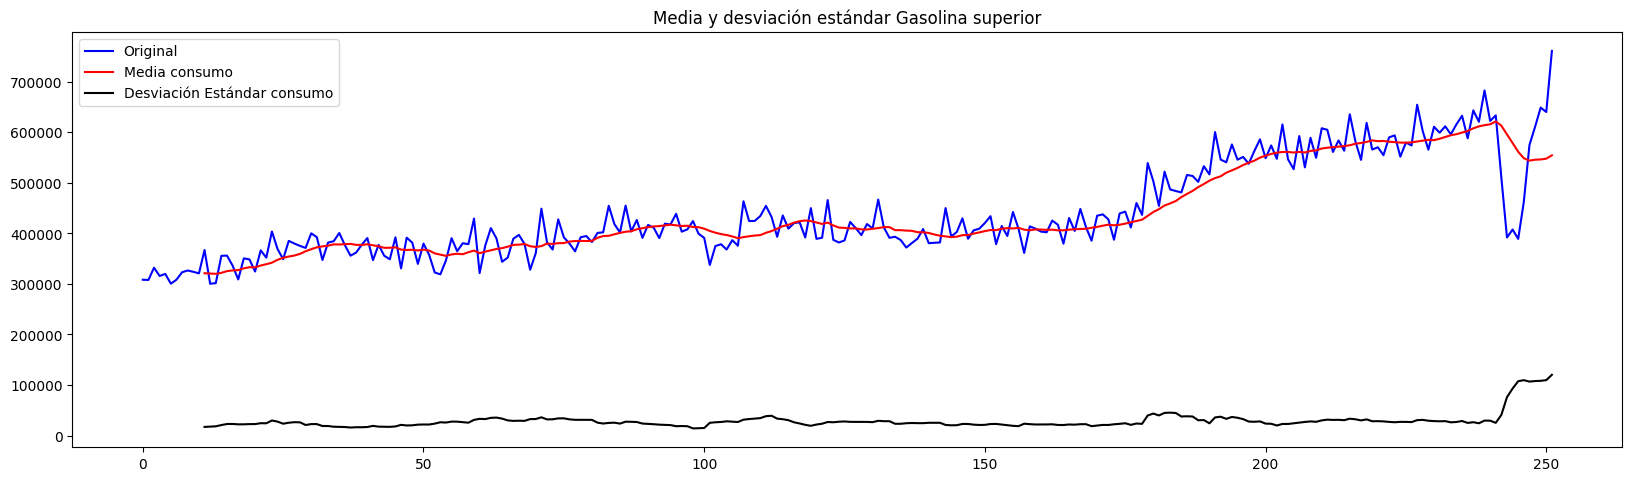

In [204]:
make_timeline(label_super)

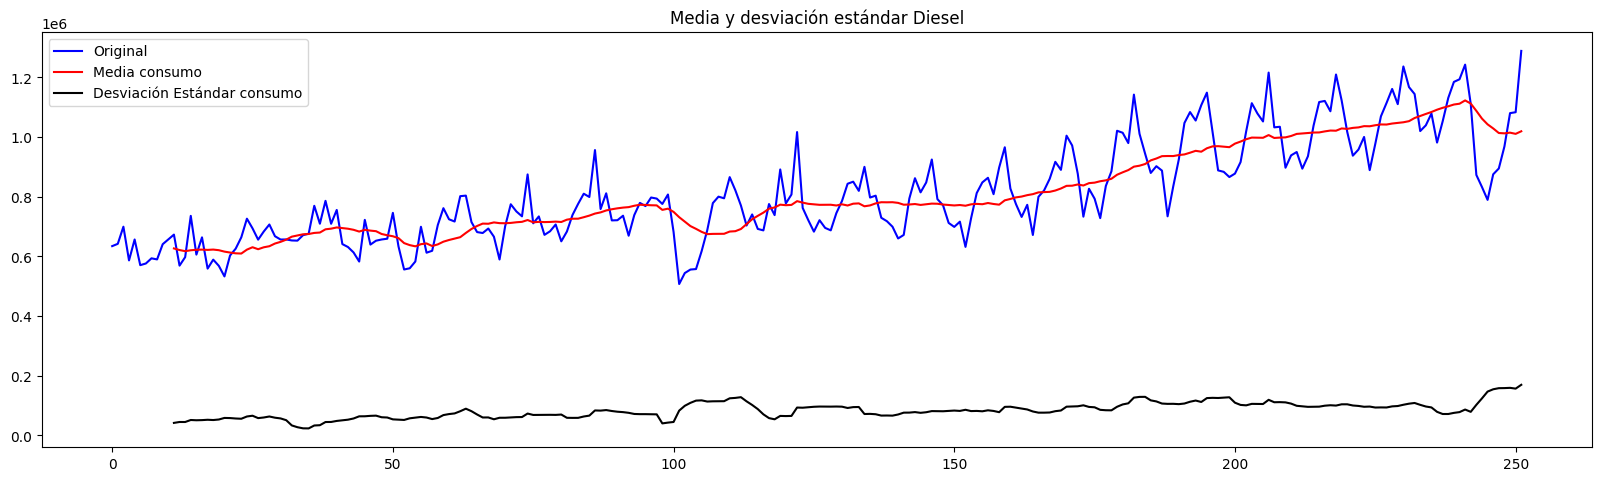

In [205]:
make_timeline(label_diesel)

In [206]:
train_regular = train_df[['Fecha', label_regular]]
train_superior = train_df[['Fecha', label_super]]
train_diesel = train_df[['Fecha', label_diesel]]

test_regular = test_df[['Fecha', label_regular]]
test_superior = test_df[['Fecha', label_super]]
test_diesel = test_df[['Fecha', label_diesel]]

In [273]:
# Gasolina regular
train_regular[label_regular] = train_regular[label_regular].astype(float)
train_regular_indexed = train_regular.set_index(['Fecha'])
# Gasolina superior
train_superior[label_super] = train_superior[label_super].astype(float)
train_superior_indexed = train_superior.set_index(['Fecha'])
# Gasolina diesel
train_diesel[label_diesel] = train_diesel[label_diesel].astype(float)
train_diesel_indexed = train_diesel.set_index(['Fecha'])


######### TEST ###############
# Gasolina regular
test_regular[label_regular] = test_regular[label_regular].astype(float)
test_regular_indexed = test_regular.set_index(['Fecha'])
# Gasolina superior
test_superior[label_super] = test_superior[label_super].astype(float)
test_superior_indexed = test_superior.set_index(['Fecha'])
# Gasolina diesel
test_diesel[label_diesel] = test_diesel[label_diesel].astype(float)
test_diesel_indexed = test_diesel.set_index(['Fecha'])

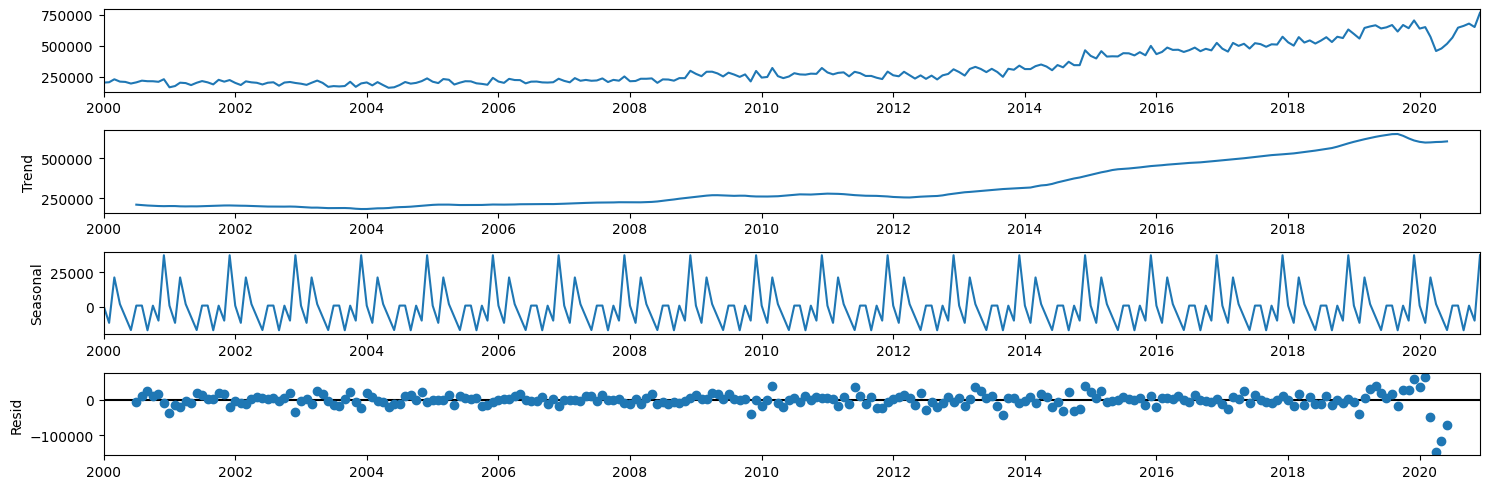

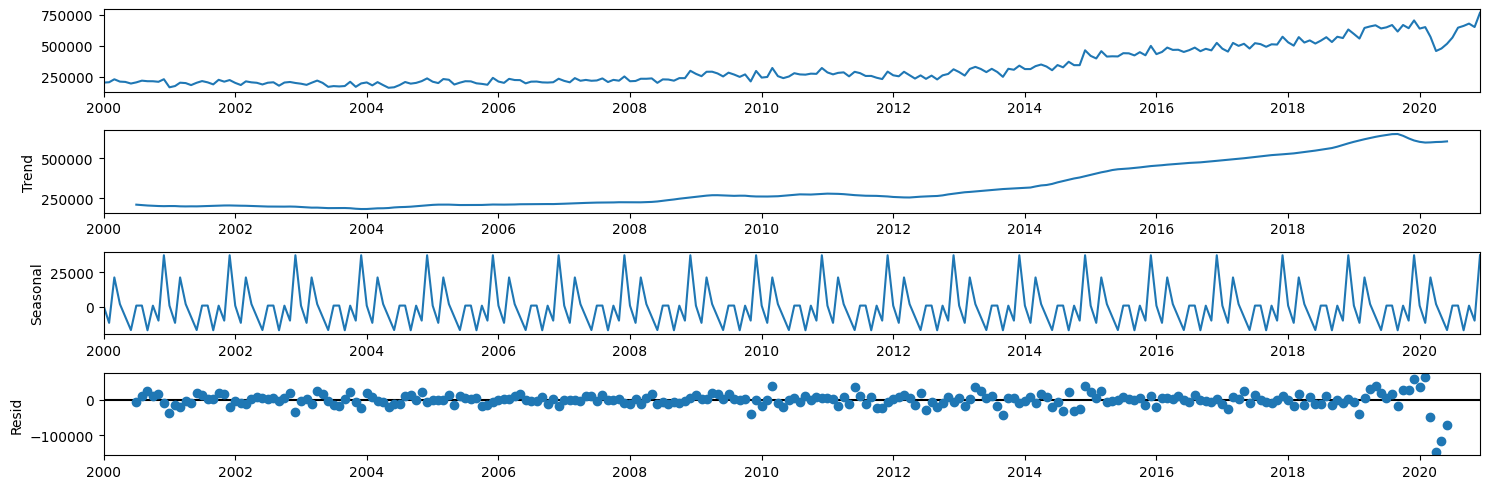

In [275]:
descomposicion = seasonal_decompose(train_regular_indexed)
descomposicion.plot()

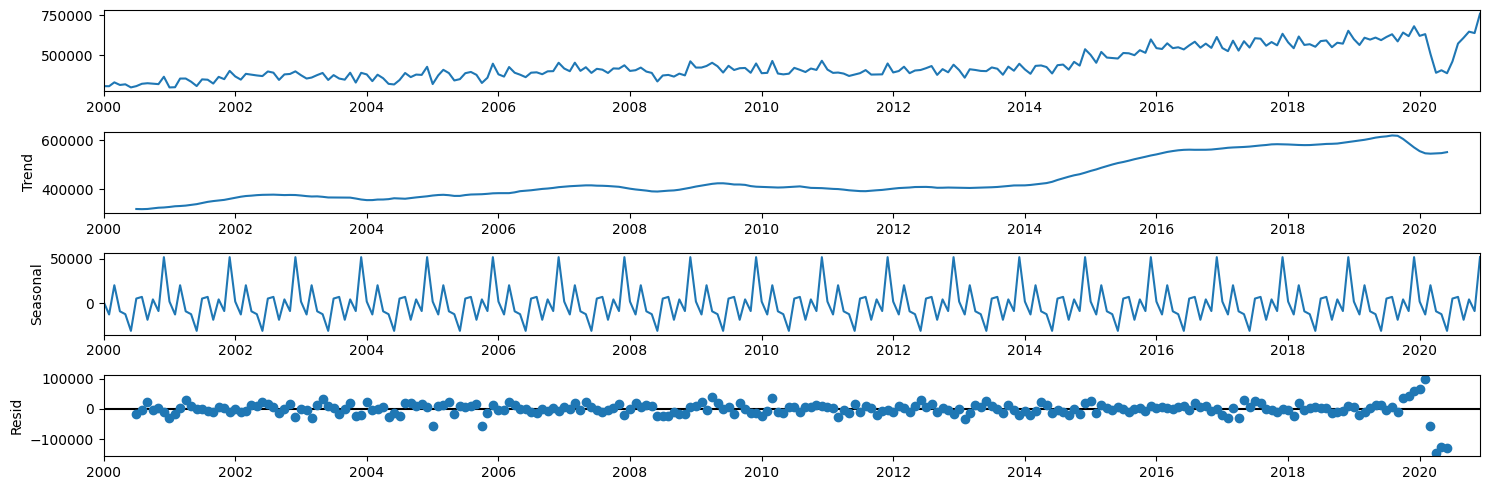

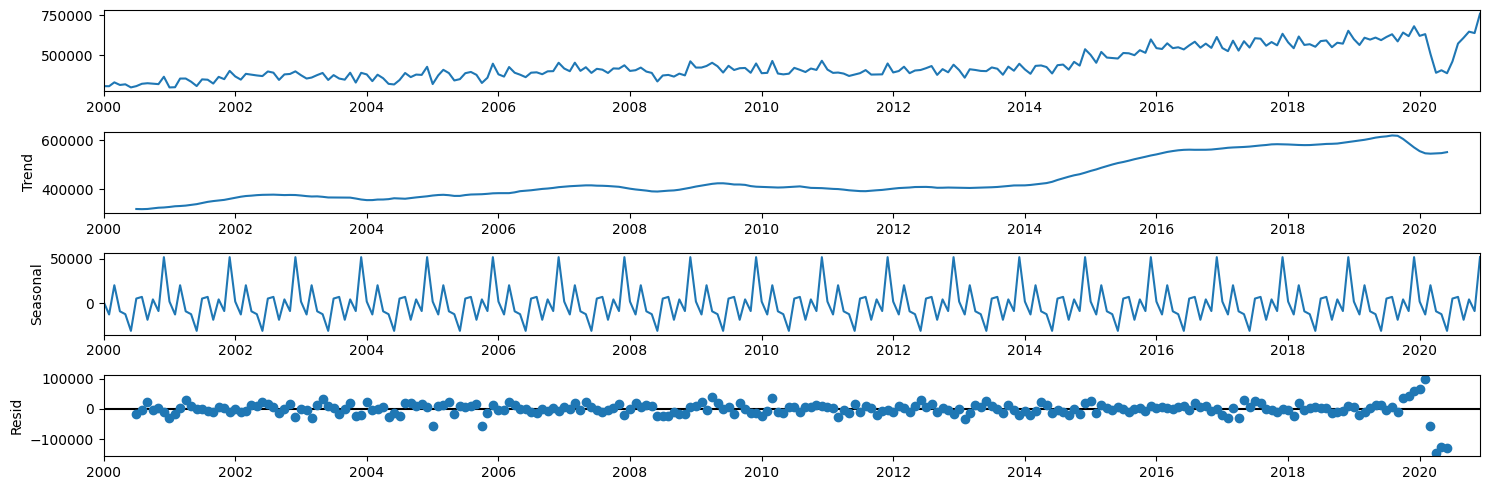

In [276]:
descomposicion = seasonal_decompose(train_superior_indexed)
descomposicion.plot()

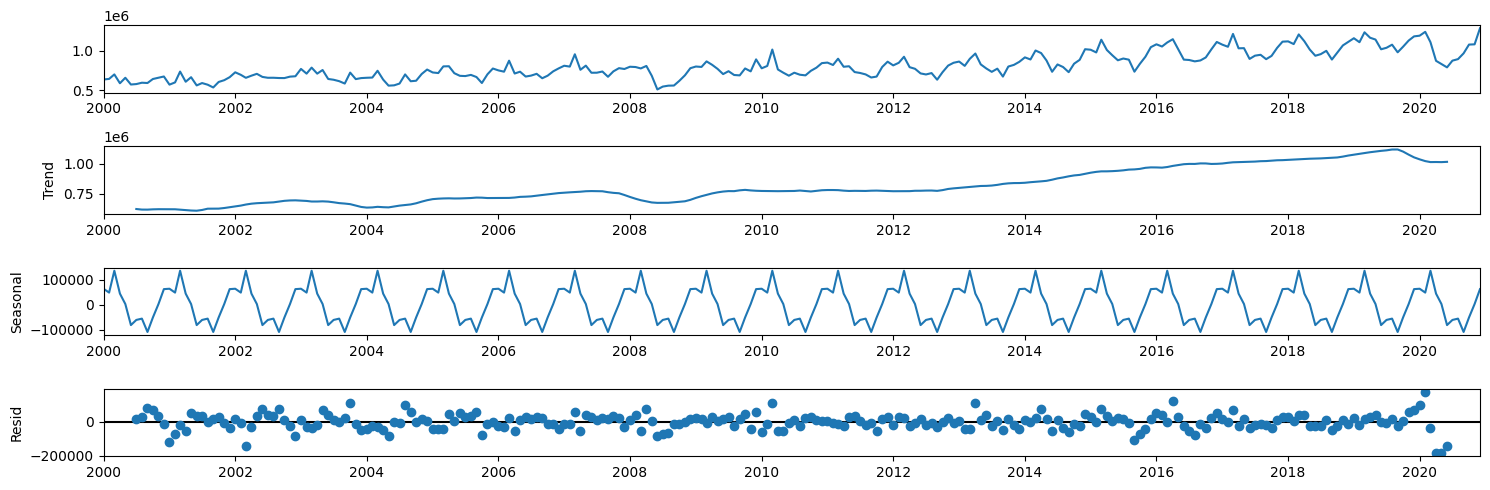

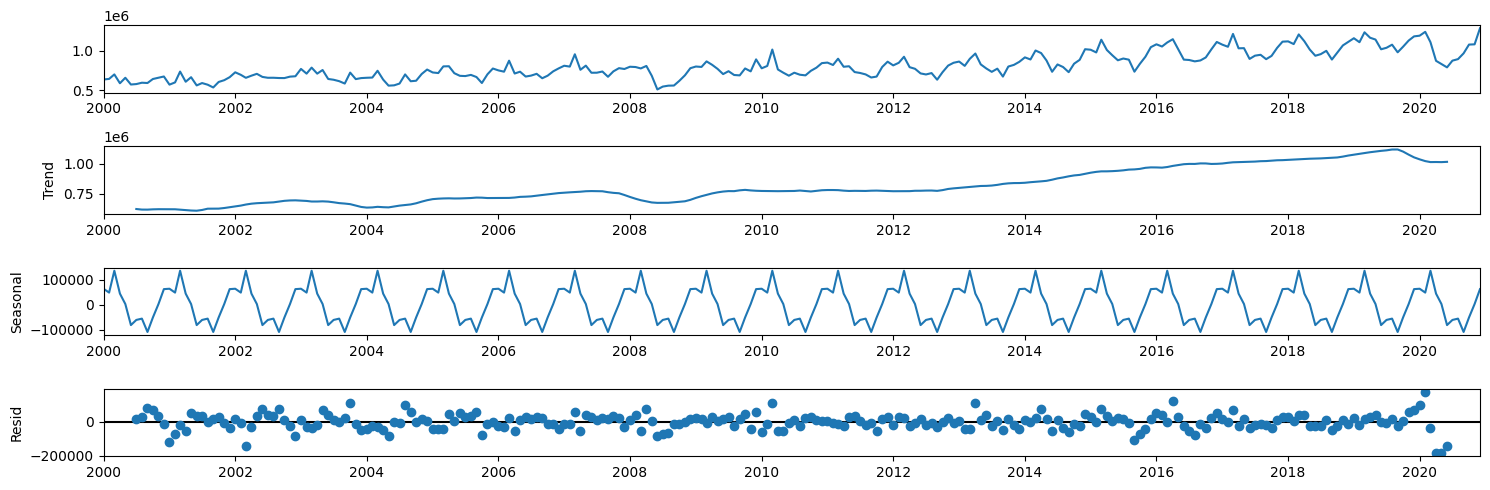

In [277]:
descomposicion = seasonal_decompose(train_diesel_indexed)
descomposicion.plot()

# Estimación

In [278]:
train_regular_indexed = train_regular_indexed[0:240]
train_superior_indexed = train_superior_indexed[0:240]
train_diesel_indexed = train_diesel_indexed[0:240]

In [279]:
train_regular_gas = train_regular_indexed[label_regular]
train_superior_gas = train_superior_indexed[label_super]
train_diesel_gas = train_diesel_indexed[label_diesel]

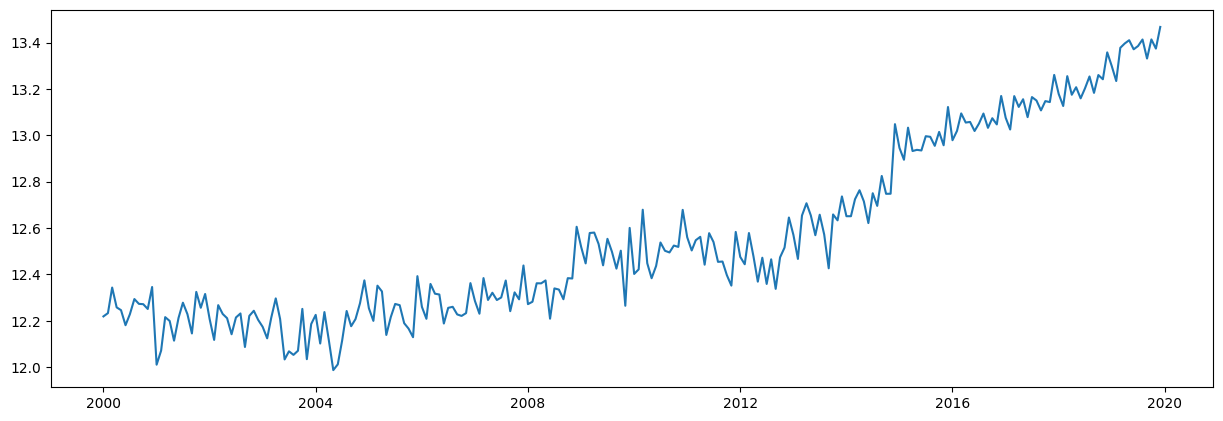

In [280]:
train_regular_log = np.log(train_regular_gas)
plt.plot(train_regular_log)

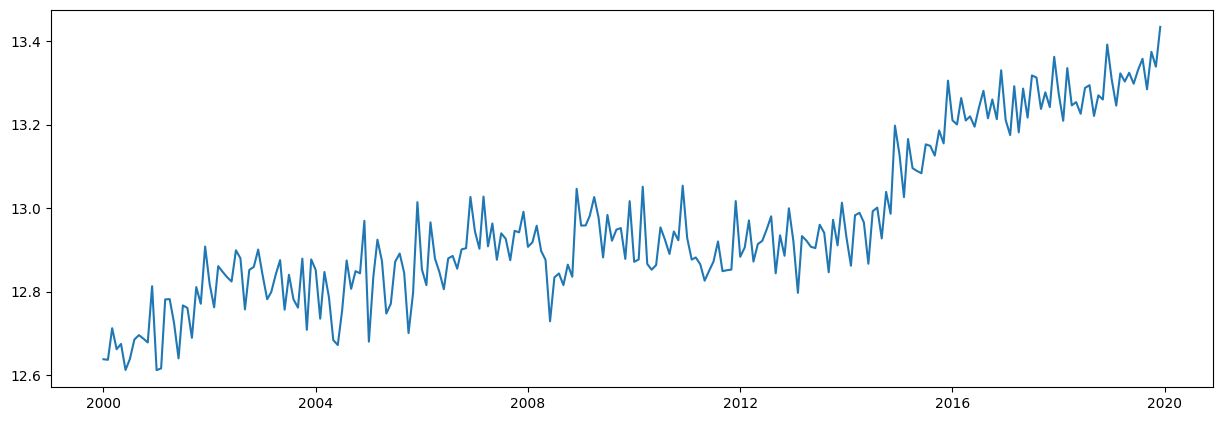

In [281]:
train_superior_log = np.log(train_superior_gas)
plt.plot(train_superior_log)

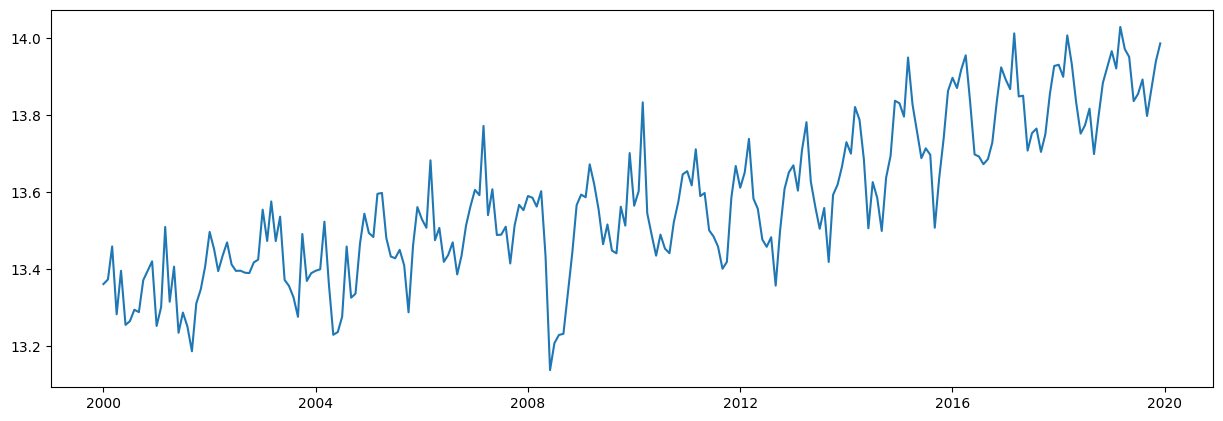

In [282]:
train_diesel_log = np.log(train_diesel_gas)
plt.plot(train_diesel_log)

Con esta transformación pudimos estacionarizarla en varianza debido a que los picos se mantienen

## Regular

In [283]:
print('Resultados del Test de Dickey Fuller ' + label_regular)
dfTest = adfuller(train_regular_gas, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller Gasolina regular
Estadístico de prueba          3.154508
p-value                        1.000000
# de retardos usados          12.000000
# de observaciones usadas    227.000000
Critical Value (1%)           -3.459490
Critical Value (5%)           -2.874358
Critical Value (10%)          -2.573602
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [284]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie ' + label_regular)
train_regular_gas_log_diff = train_regular_gas.diff()
train_regular_gas_log_diff.dropna(inplace=True)
dfTest = adfuller(train_regular_gas_log_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie Gasolina regular
Estadístico de prueba         -3.431888
p-value                        0.009919
# de retardos usados          12.000000
# de observaciones usadas    226.000000
Critical Value (1%)           -3.459620
Critical Value (5%)           -2.874415
Critical Value (10%)          -2.573632
dtype: float64


El p-value es menor a 0.05 por lo que se rechaza la hipótesis nula. La serie es estacionaria en media con un d=1

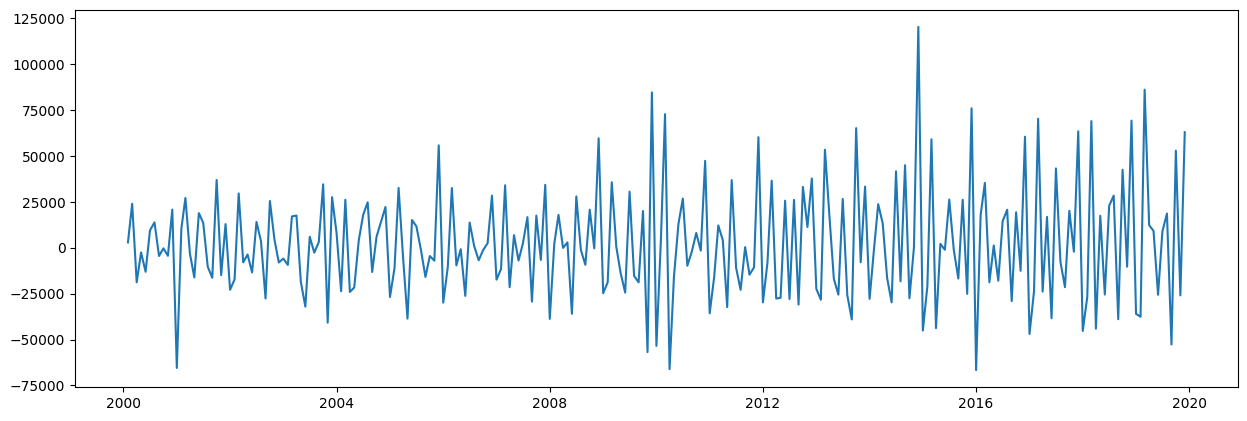

In [285]:
plt.plot(train_regular_gas_log_diff)

## Superior

In [286]:
print('Resultados del Test de Dickey Fuller ' + label_super)
dfTest = adfuller(train_superior_gas, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller Gasolina superior
Estadístico de prueba          0.745940
p-value                        0.990711
# de retardos usados          12.000000
# de observaciones usadas    227.000000
Critical Value (1%)           -3.459490
Critical Value (5%)           -2.874358
Critical Value (10%)          -2.573602
dtype: float64


In [287]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie ' + label_super)
train_superior_gas_log_diff = train_superior_gas.diff()
train_superior_gas_log_diff.dropna(inplace=True)
dfTest = adfuller(train_superior_gas_log_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie Gasolina superior
Estadístico de prueba         -4.887201
p-value                        0.000037
# de retardos usados          11.000000
# de observaciones usadas    227.000000
Critical Value (1%)           -3.459490
Critical Value (5%)           -2.874358
Critical Value (10%)          -2.573602
dtype: float64


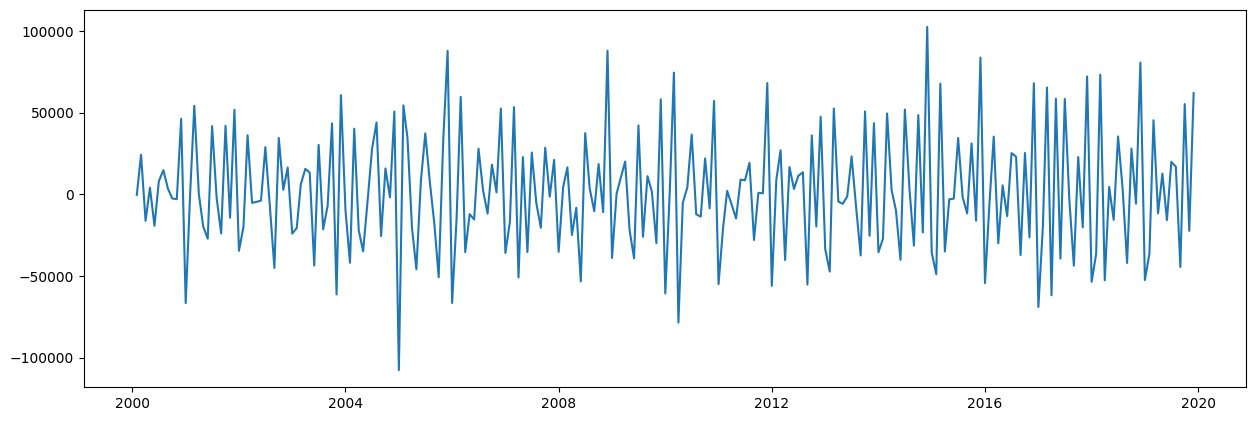

In [288]:
plt.plot(train_superior_gas_log_diff)

## Diesel

In [289]:
print('Resultados del Test de Dickey Fuller ' + label_diesel)
dfTest = adfuller(train_diesel_gas, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller Diesel
Estadístico de prueba          0.703373
p-value                        0.989905
# de retardos usados          12.000000
# de observaciones usadas    227.000000
Critical Value (1%)           -3.459490
Critical Value (5%)           -2.874358
Critical Value (10%)          -2.573602
dtype: float64


In [290]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie ' + label_diesel)
train_diesel_gas_log_diff = train_diesel_gas.diff()
train_diesel_gas_log_diff.dropna(inplace=True)
dfTest = adfuller(train_diesel_gas_log_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie Diesel
Estadístico de prueba       -6.736513e+00
p-value                      3.197394e-09
# de retardos usados         1.100000e+01
# de observaciones usadas    2.270000e+02
Critical Value (1%)         -3.459490e+00
Critical Value (5%)         -2.874358e+00
Critical Value (10%)        -2.573602e+00
dtype: float64


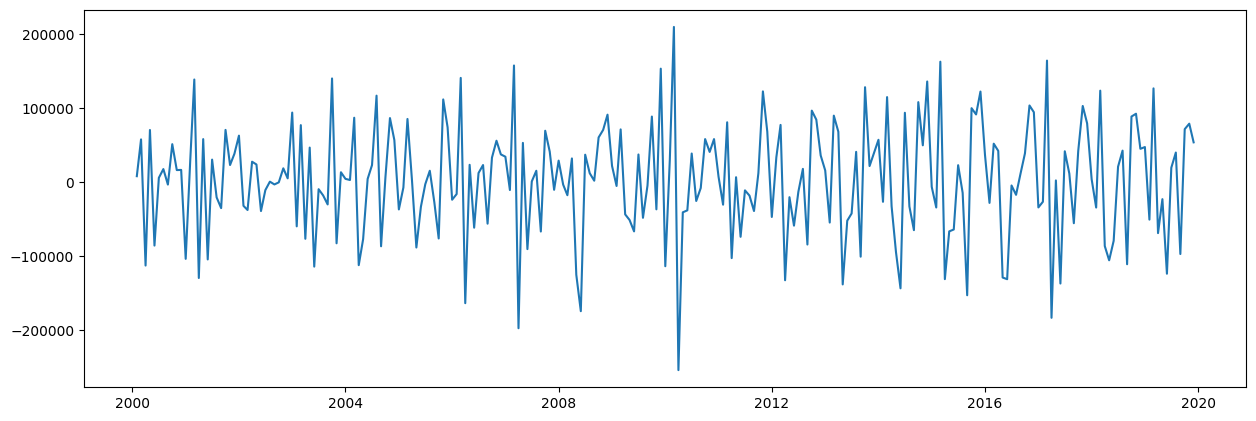

In [291]:
plt.plot(train_diesel_gas_log_diff)

## Funciones de autocorrelación
#### Modelos teóricos


| Modelo    |                FAC                |                FACP               |
|-----------|:---------------------------------:|:---------------------------------:|
|   **MA(q)**   |         Se anula para j>q         | Decrecimiento rápido. No se anula |
|   **AR(p)**   | Decrecimiento rápido. No se anula |         Se anula para j>p         |
| **ARMA(p,q)** | Decrecimiento rápido. No se anula | Decrecimiento rápido. No se anula |  

In [292]:
def getTSA(train_gas_diff):
  tsa_acf = acf(train_gas_diff,nlags=5,fft=False)
  tsa_pacf = pacf(train_gas_diff, nlags=36)
  return [tsa_acf, tsa_pacf]

In [293]:
def plotACF(train_gas_diff):
  plt.rcParams['figure.figsize'] = [15, 5]
  plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

  #Plot ACF: 
  plt.subplot(121) 
  plt.plot(acf(train_gas_diff,nlags=36,fft=False))
  plt.axhline(y=0,linestyle='--',color='gray')
  plt.axhline(y=-1.96/np.sqrt(len(train_gas_diff)),linestyle='--',color='gray')
  plt.axhline(y=1.96/np.sqrt(len(train_gas_diff)),linestyle='--',color='gray')
  plt.title('Función de Autocorrelación con 36 retardos')

  plt.subplot(122) 
  plt.plot(acf(train_gas_diff,nlags=5,fft=False))
  plt.axhline(y=0,linestyle='--',color='gray')
  plt.axhline(y=-1.96/np.sqrt(len(train_gas_diff)),linestyle='--',color='gray')
  plt.axhline(y=1.96/np.sqrt(len(train_gas_diff)),linestyle='--',color='gray')
  plt.title('Función de Autocorrelación con 5 retardos')

  plt.tight_layout()

In [294]:
#plot PACF
def plotPACF(train_gas_diff):
  plt.subplot(121)
  plt.plot(pacf(train_gas_diff, nlags=36))
  plt.axhline(y=0,linestyle='--',color='gray')
  plt.axhline(y=-1.96/np.sqrt(len(train_gas_diff)),linestyle='--',color='gray')
  plt.axhline(y=1.96/np.sqrt(len(train_gas_diff)),linestyle='--',color='gray')
  plt.title('Función de Autocorrelación Parcial 36 retardos')

  plt.subplot(122)
  plt.plot(pacf(train_gas_diff, nlags=5))
  plt.axhline(y=0,linestyle='--',color='gray')
  plt.axhline(y=-1.96/np.sqrt(len(train_gas_diff)),linestyle='--',color='gray')
  plt.axhline(y=1.96/np.sqrt(len(train_gas_diff)),linestyle='--',color='gray')
  plt.title('Función de Autocorrelación Parcial 5 retardos')

  plt.rcParams['figure.figsize'] = [15, 5]
  plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [295]:
def checkStationarity(train_gas_diff):
  plt.plot(acf(train_gas_diff,nlags=36,fft=False))
  plt.axhline(y=0,linestyle='--',color='gray')
  plt.axhline(y=-1.96/np.sqrt(len(train_gas_diff)),linestyle='--',color='gray')
  plt.axhline(y=1.96/np.sqrt(len(train_gas_diff)),linestyle='--',color='gray')
  plt.title('Función de Autocorrelación con 36 retardos')
  plt.rcParams['figure.figsize'] = [15, 5]
  plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [296]:
def autoCorr(train_log_diff):
  plt.plot(pacf(train_log_diff, nlags=8))
  plt.axhline(y=0,linestyle='--',color='gray')
  plt.axhline(y=-1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
  plt.axhline(y=1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
  plt.title('Función de Autocorrelación Parcial 8 retardos')

### Regular

In [297]:
train_regular_gas_diff = train_regular_log.diff()
train_regular_gas_diff.dropna(inplace = True)
[tsa_acf_regular, tsa_pacf_regular] = getTSA(train_regular_gas_diff)
tsa_acf_regular

array([ 1.        , -0.43251711, -0.14227986,  0.14891018, -0.04858585,
        0.15916638])

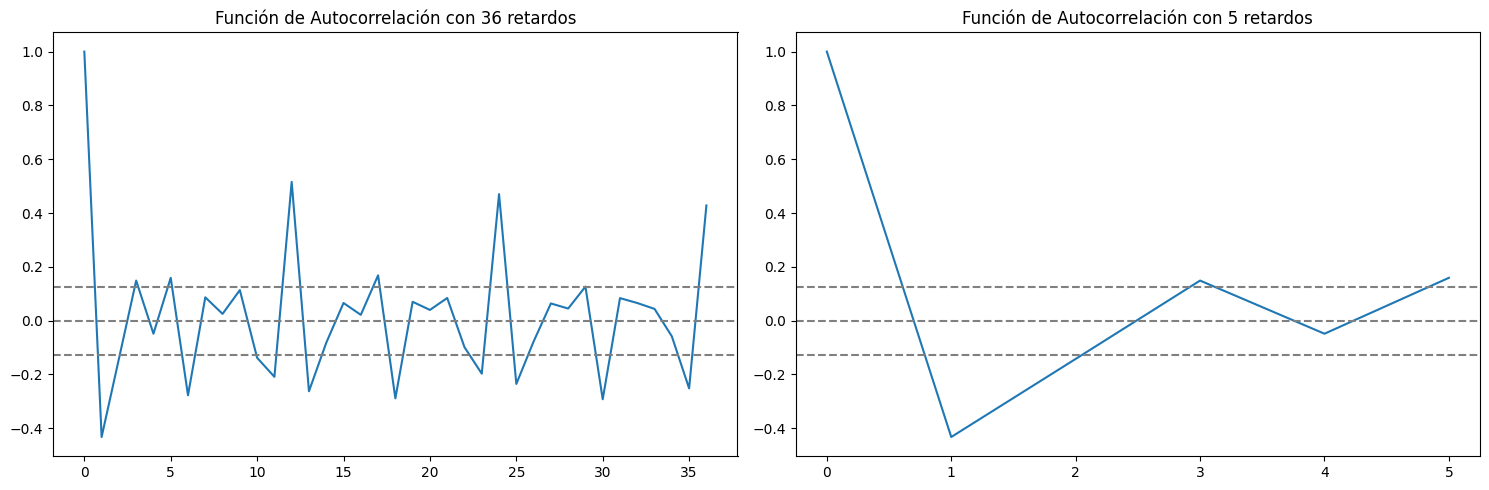

In [298]:
plotACF(train_regular_gas_diff)

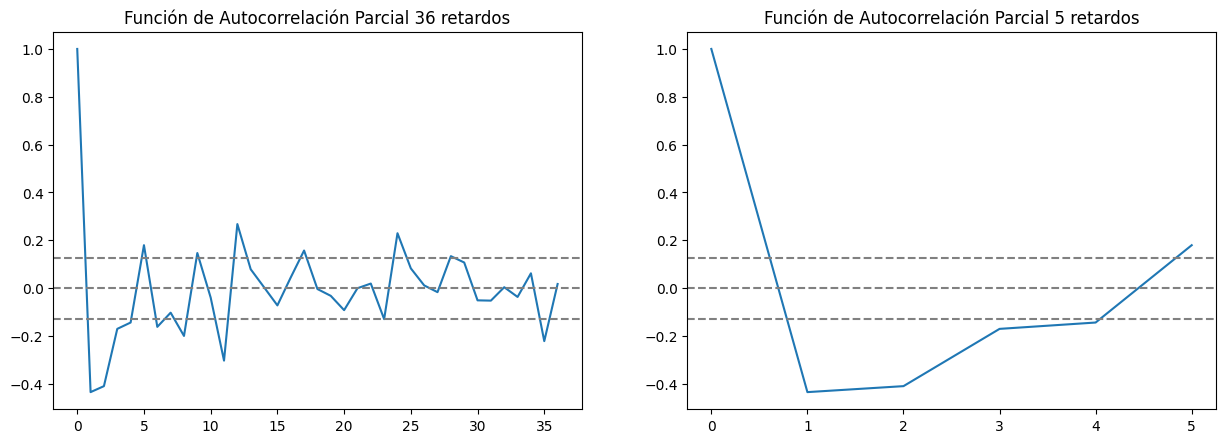

In [299]:
plotPACF(train_regular_gas_diff)

- Al verificar ACF el modelo no se anula
- Al verificar PACF el modelo no se anula

---> Se acerca a un ARMA

#### Estacionariedad

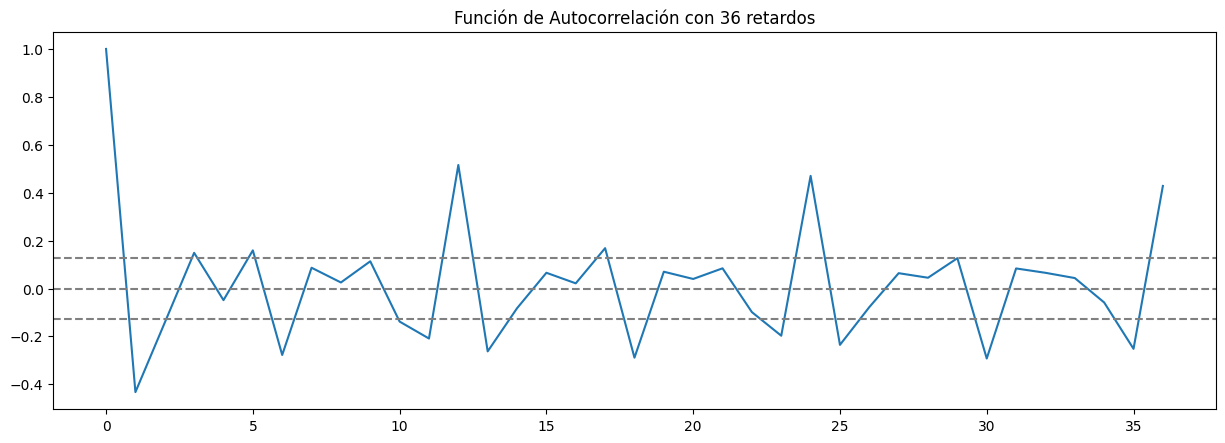

In [300]:
checkStationarity(train_regular_gas_diff)

Como se puede observar el comportamiento es similar entre 3 - 12 y 15 - 24 (estacionalidad)

In [301]:
train_regular_log_diff = train_regular_log.diff(12)
train_regular_log_diff.dropna(inplace=True)

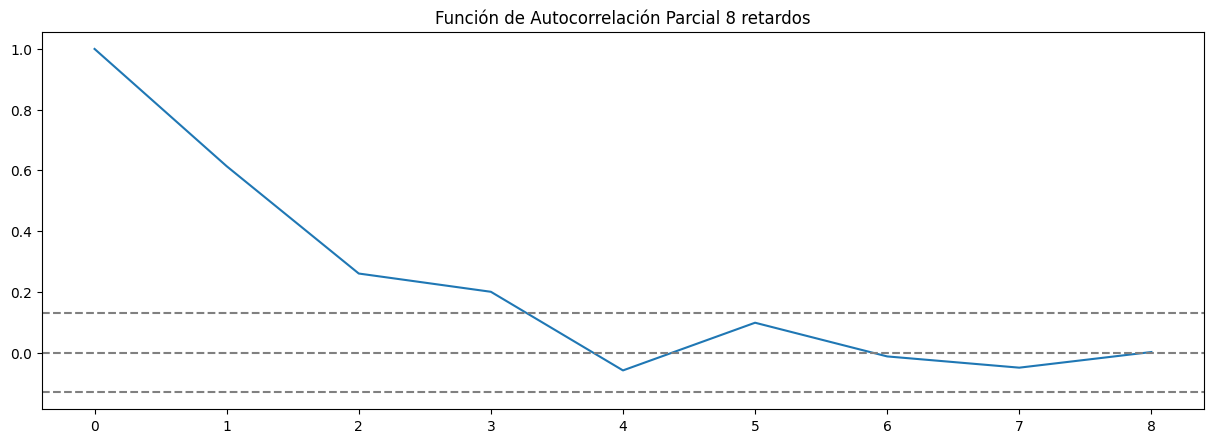

In [302]:
autoCorr(train_regular_log_diff)

Luego de hacer una diferenciación estacional, podemos observar que prácticamente se anulan los coeficientes después de p=3. 
- P = 3
- D = 1
- Q = 0

### Superior

In [303]:
train_superior_gas_diff = train_superior_log.diff()
train_superior_gas_diff.dropna(inplace = True)
[tsa_acf_superior, tsa_pacf_superior] = getTSA(train_superior_gas_diff)
tsa_acf_superior

array([ 1.        , -0.46590157, -0.11363866,  0.09554375, -0.01092253,
        0.26389341])

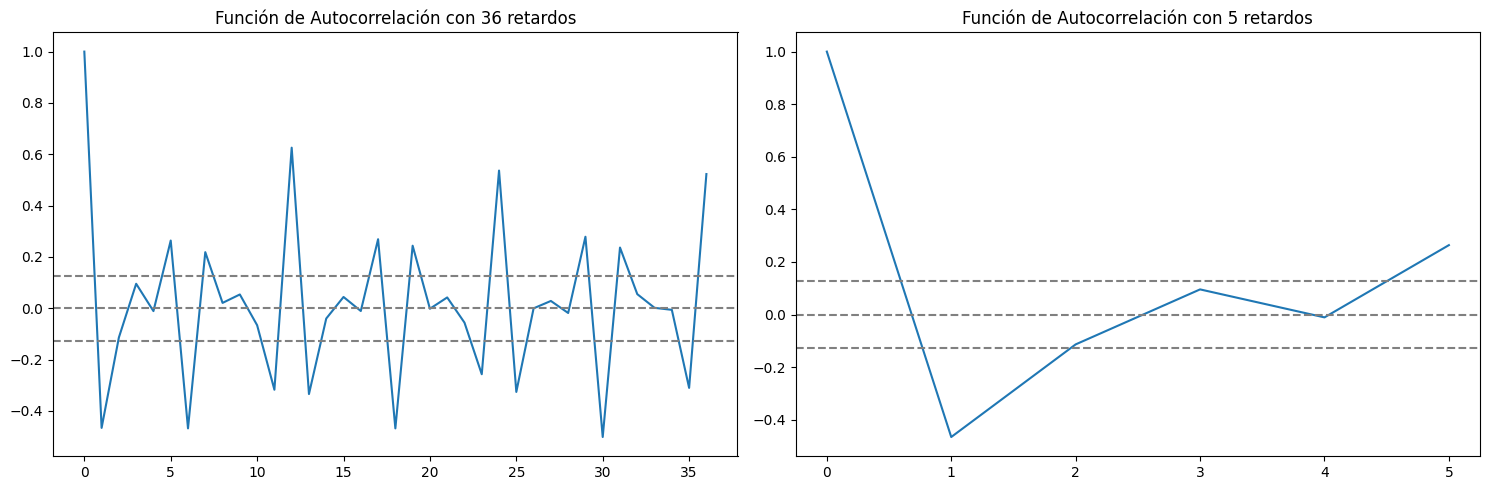

In [304]:
plotACF(train_superior_gas_diff)

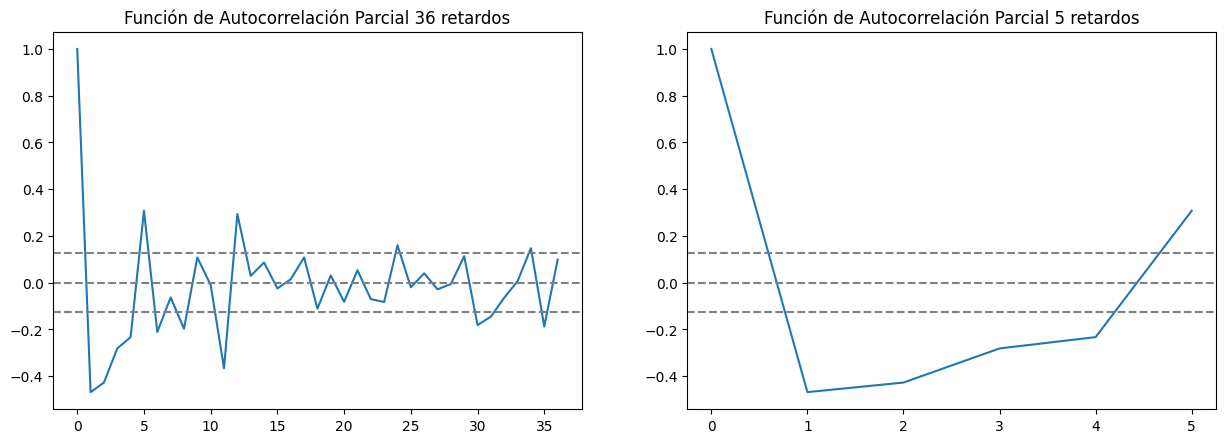

In [305]:
plotPACF(train_superior_gas_diff)

- Al verificar ACF el modelo no se anula
- Al verificar PACF el modelo no se anula

---> Se acerca a un ARMA

#### Estacionariedad

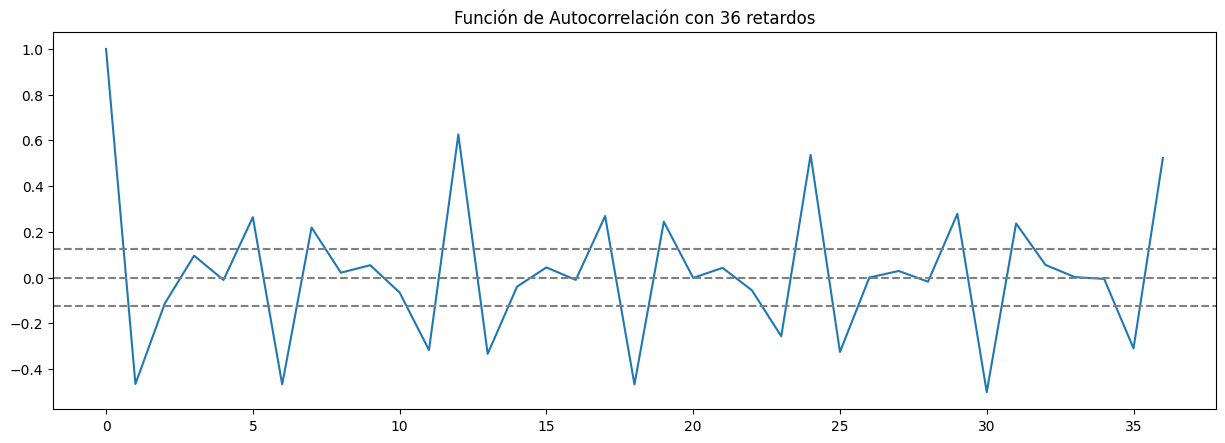

In [306]:
checkStationarity(train_superior_gas_diff)

In [307]:
train_superior_log_diff = train_superior_log.diff(12)
train_superior_log_diff.dropna(inplace=True)

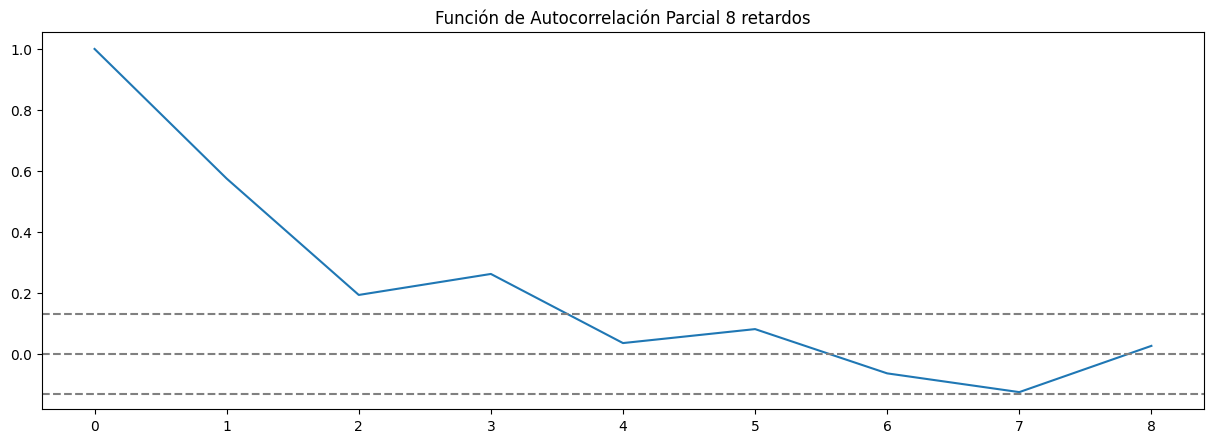

In [308]:
autoCorr(train_superior_log_diff)

Luego de hacer una diferenciación estacional, podemos observar que prácticamente se anulan los coeficientes después de p=3. 
- P = 5
- D = 1
- Q = 0

### Diesel

In [309]:
train_diesel_gas_diff = train_diesel_log.diff()
train_diesel_gas_diff.dropna(inplace = True)
[tsa_acf_diesel, tsa_pacf_diesel] = getTSA(train_diesel_gas_diff)
tsa_acf_diesel

array([ 1.        , -0.2053634 ,  0.01226058,  0.02165248, -0.06555712,
        0.02969765])

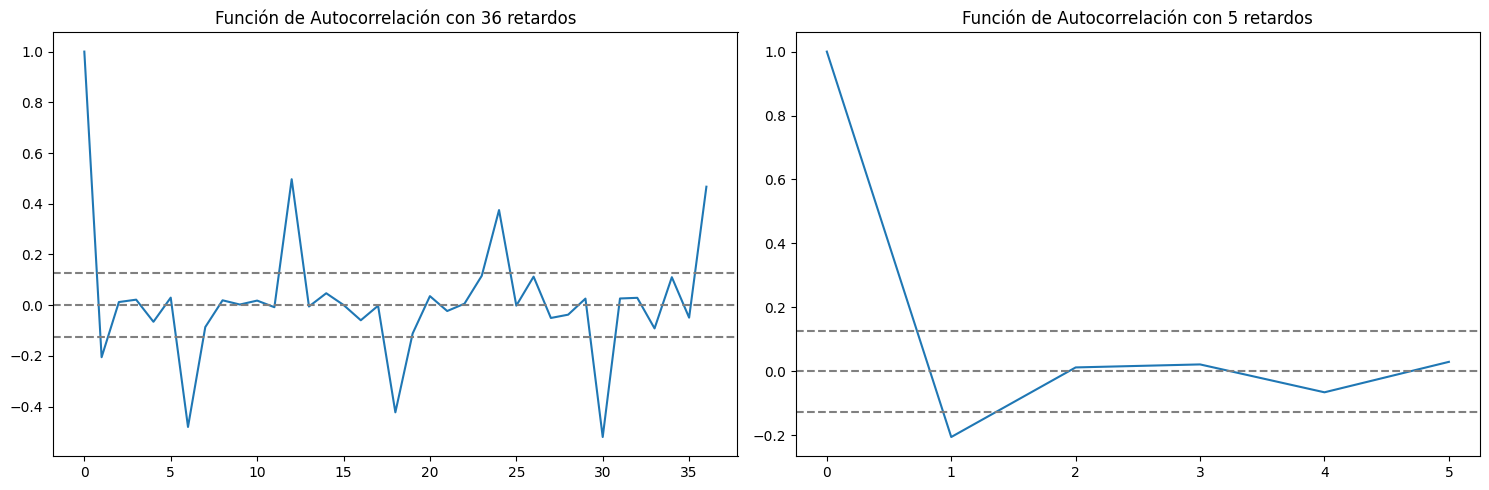

In [310]:
plotACF(train_diesel_gas_diff)

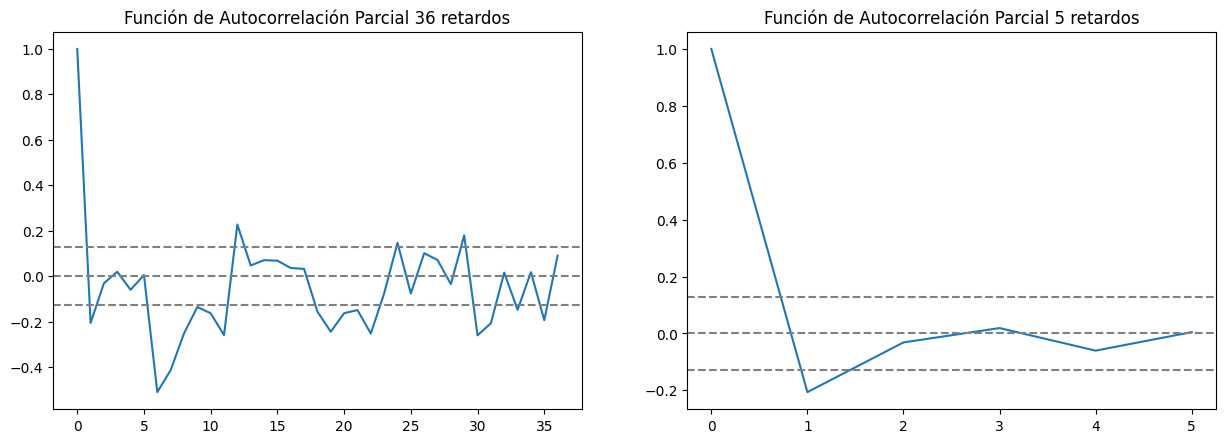

In [311]:
plotPACF(train_diesel_gas_diff)

- Al verificar ACF el modelo no se anula
- Al verificar PACF el modelo no se anula

---> Se acerca a un ARMA

#### Estacionariedad

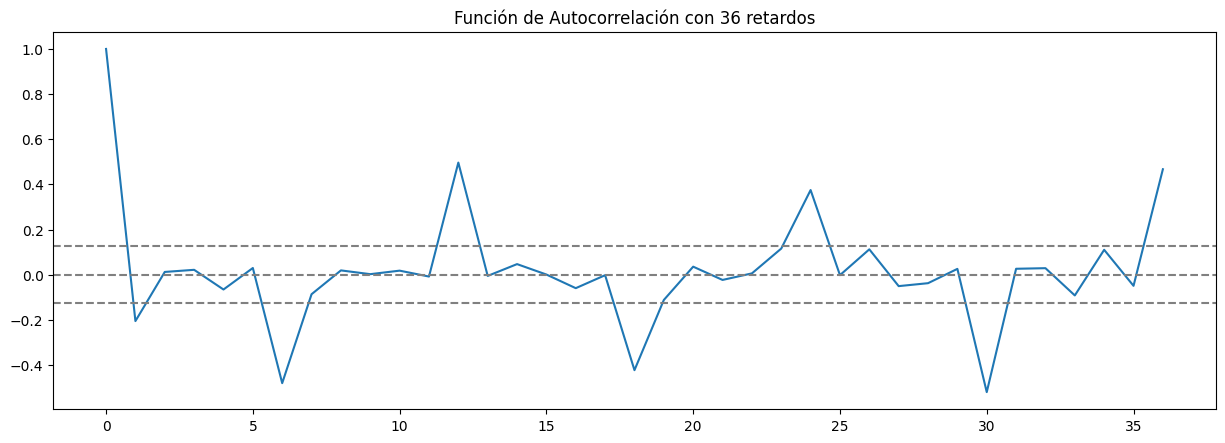

In [312]:
checkStationarity(train_diesel_gas_diff)

In [313]:
train_diesel_log_diff = train_diesel_log.diff(12)
train_diesel_log_diff.dropna(inplace=True)

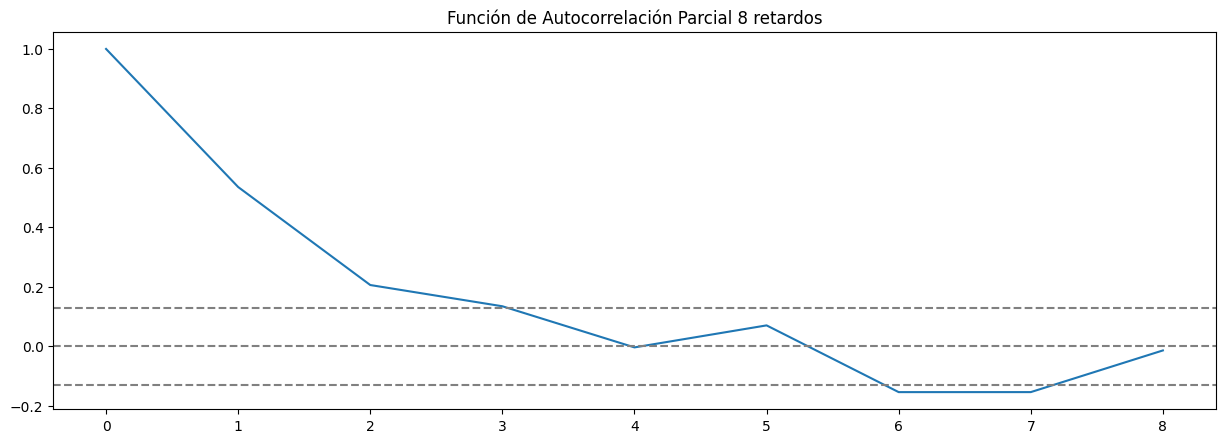

In [314]:
autoCorr(train_diesel_log_diff)

Luego de hacer una diferenciación estacional, podemos observar que prácticamente se anulan los coeficientes después de p=3. 
- P = 3
- D = 1
- Q = 0

## Analisis residuos

## Regular

In [315]:
model_regular_121 = SARIMAX(
  train_regular_log,
  order=(1,2,1),
  seasonal_order=(3,1,0,12),
  enforce_stationarity=False,
  enforce_invertibility=False
)
resultado_regular_121 = model_regular_121.fit()
print(resultado_regular_121.summary().tables[1])

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4416      0.062     -7.089      0.000      -0.564      -0.320
ma.L1         -1.0000    413.502     -0.002      0.998    -811.448     809.448
ar.S.L12      -0.7042      0.057    -12.461      0.000      -0.815      -0.593
ar.S.L24      -0.4608      0.078     -5.911      0.000      -0.614      -0.308
ar.S.L36      -0.2647      0.070     -3.799      0.000      -0.401      -0.128
sigma2         0.0047      1.928      0.002      0.998      -3.773       3.783


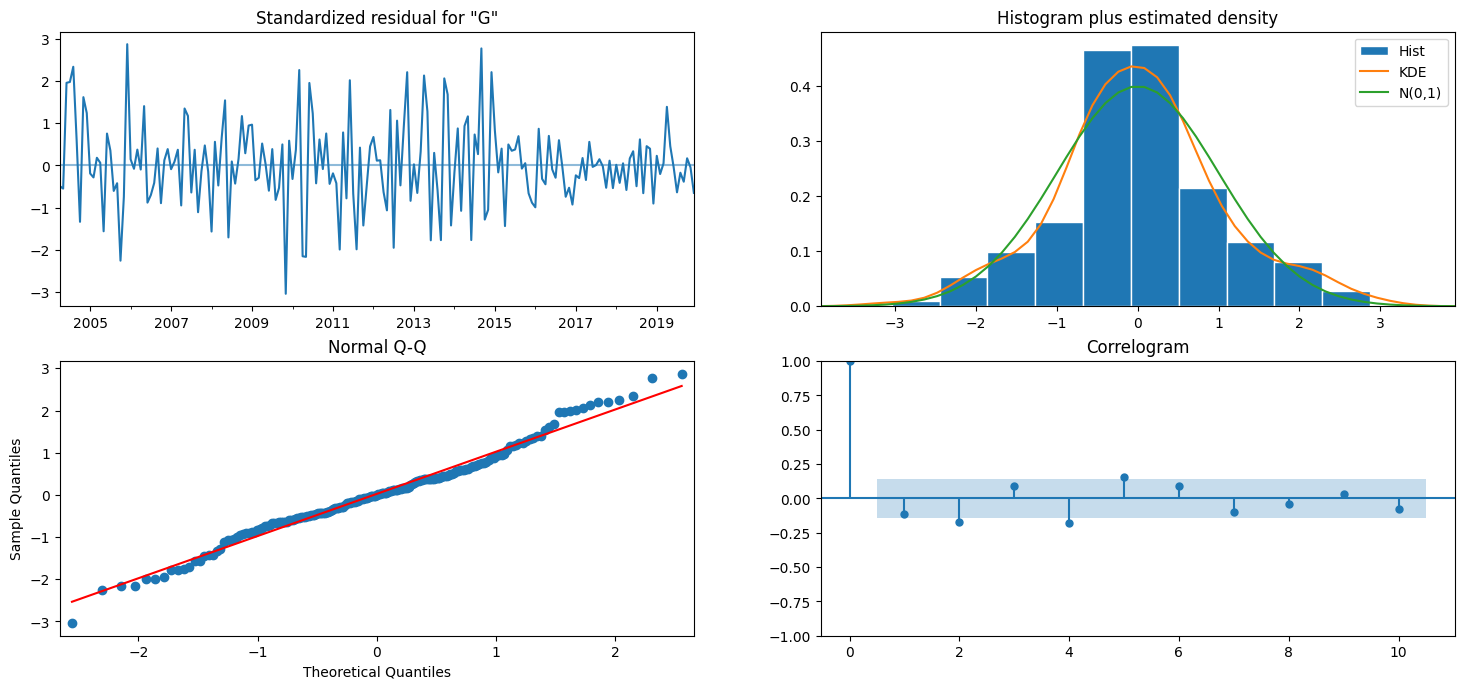

In [316]:
resultado_regular_121.plot_diagnostics(figsize=(18, 8))
plt.show()

In [317]:
model_regular_221 = SARIMAX(
  train_regular_log,
  order=(2,2,1),
  seasonal_order=(2,1,0,12),
  enforce_stationarity=False,
  enforce_invertibility=False
)
resultado_regular_221 = model_regular_221.fit(disp=False)
print(resultado_regular_221.summary().tables[1])

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5231      0.067     -7.752      0.000      -0.655      -0.391
ar.L2         -0.2735      0.062     -4.393      0.000      -0.396      -0.151
ma.L1         -1.0000    243.355     -0.004      0.997    -477.968     475.968
ar.S.L12      -0.6206      0.065     -9.496      0.000      -0.749      -0.493
ar.S.L24      -0.2772      0.065     -4.264      0.000      -0.405      -0.150
sigma2         0.0051      1.249      0.004      0.997      -2.443       2.453


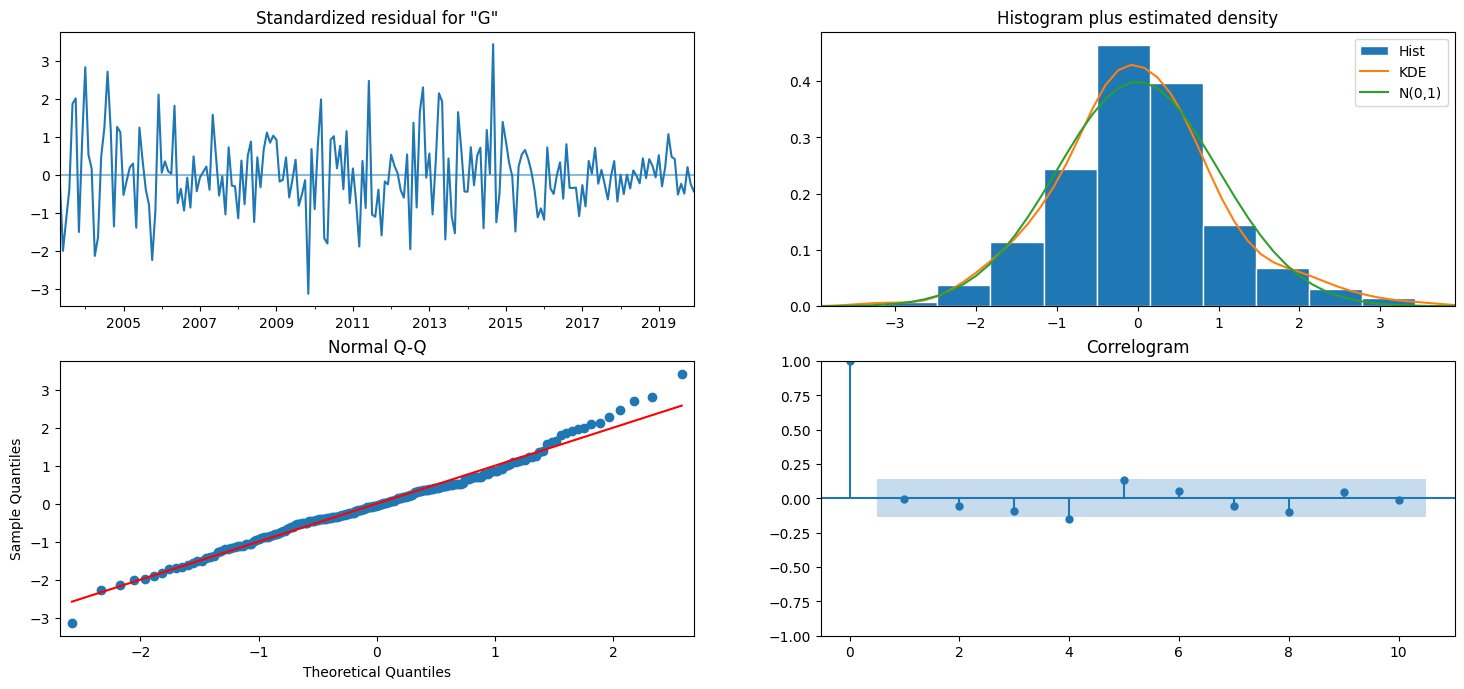

In [318]:
resultado_regular_221.plot_diagnostics(figsize=(18, 8))
plt.show()

In [319]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 121=",resultado_regular_121.aic)
print("Modelo 221=",resultado_regular_221.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 121=",resultado_regular_121.bic)
print("Modelo 221=",resultado_regular_221.bic)

Resultados de AIC (Akaike information criterion)
Modelo 121= -461.36481551613093
Modelo 221= -470.21960778667784
Resultados de BIC (Bayesian information criterion)
Modelo 121= -441.91433342577307
Modelo 221= -450.4297035873896


De acuerdo a ambos indicadores es mejor el modelo p=2, d=2, q=1 por lo que este es el que será usado para predecir pues tinene un valor menor en AIC y en BIC

## Superior

In [320]:
model_superior_121 = SARIMAX(
  train_superior_log,
  order=(1,2,1),
  seasonal_order=(5,1,0,12),
  enforce_stationarity=False,
  enforce_invertibility=False
)
resultado_superior_121 = model_superior_121.fit()
print(resultado_superior_121.summary().tables[1])

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4222      0.071     -5.961      0.000      -0.561      -0.283
ma.L1         -1.0000     19.837     -0.050      0.960     -39.880      37.880
ar.S.L12      -0.8064      0.065    -12.455      0.000      -0.933      -0.679
ar.S.L24      -0.7222      0.070    -10.391      0.000      -0.858      -0.586
ar.S.L36      -0.5696      0.074     -7.683      0.000      -0.715      -0.424
ar.S.L48      -0.4441      0.073     -6.068      0.000      -0.588      -0.301
ar.S.L60      -0.1961      0.058     -3.374      0.001      -0.310      -0.082
sigma2         0.0015      0.030      0.050      0.960      -0.058       0.061


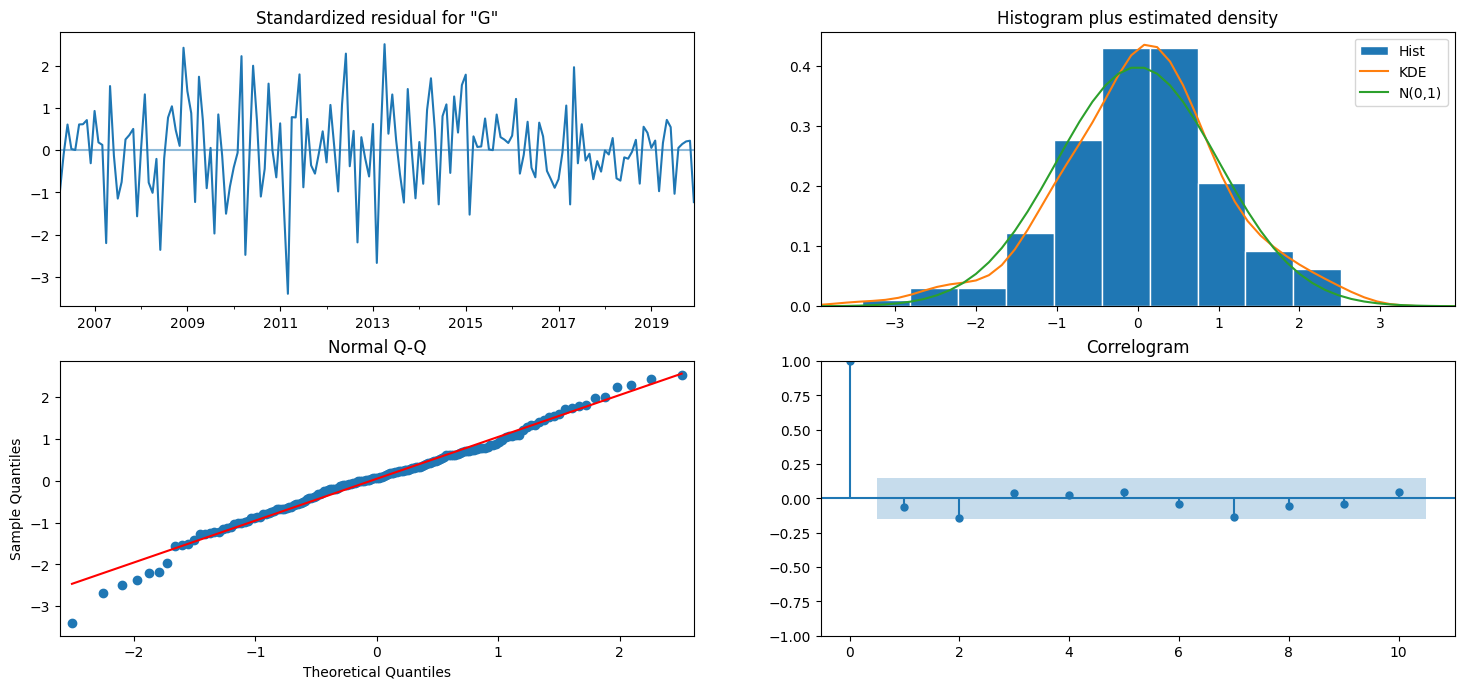

In [321]:
resultado_superior_121.plot_diagnostics(figsize=(18, 8))
plt.show()

In [322]:
model_superior_221 = SARIMAX(
  train_superior_log,
  order=(2,2,1),
  seasonal_order=(5,1,0,12),
  enforce_stationarity=False,
  enforce_invertibility=False
)
resultado_superior_221 = model_superior_221.fit(disp=False)
print(resultado_superior_221.summary().tables[1])

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4869      0.083     -5.893      0.000      -0.649      -0.325
ar.L2         -0.1639      0.080     -2.046      0.041      -0.321      -0.007
ma.L1         -1.0000     23.247     -0.043      0.966     -46.564      44.564
ar.S.L12      -0.7999      0.066    -12.177      0.000      -0.929      -0.671
ar.S.L24      -0.7118      0.077     -9.191      0.000      -0.864      -0.560
ar.S.L36      -0.5477      0.080     -6.886      0.000      -0.704      -0.392
ar.S.L48      -0.4142      0.078     -5.306      0.000      -0.567      -0.261
ar.S.L60      -0.1978      0.059     -3.328      0.001      -0.314      -0.081
sigma2         0.0015      0.034      0.043      0.966      -0.066       0.069


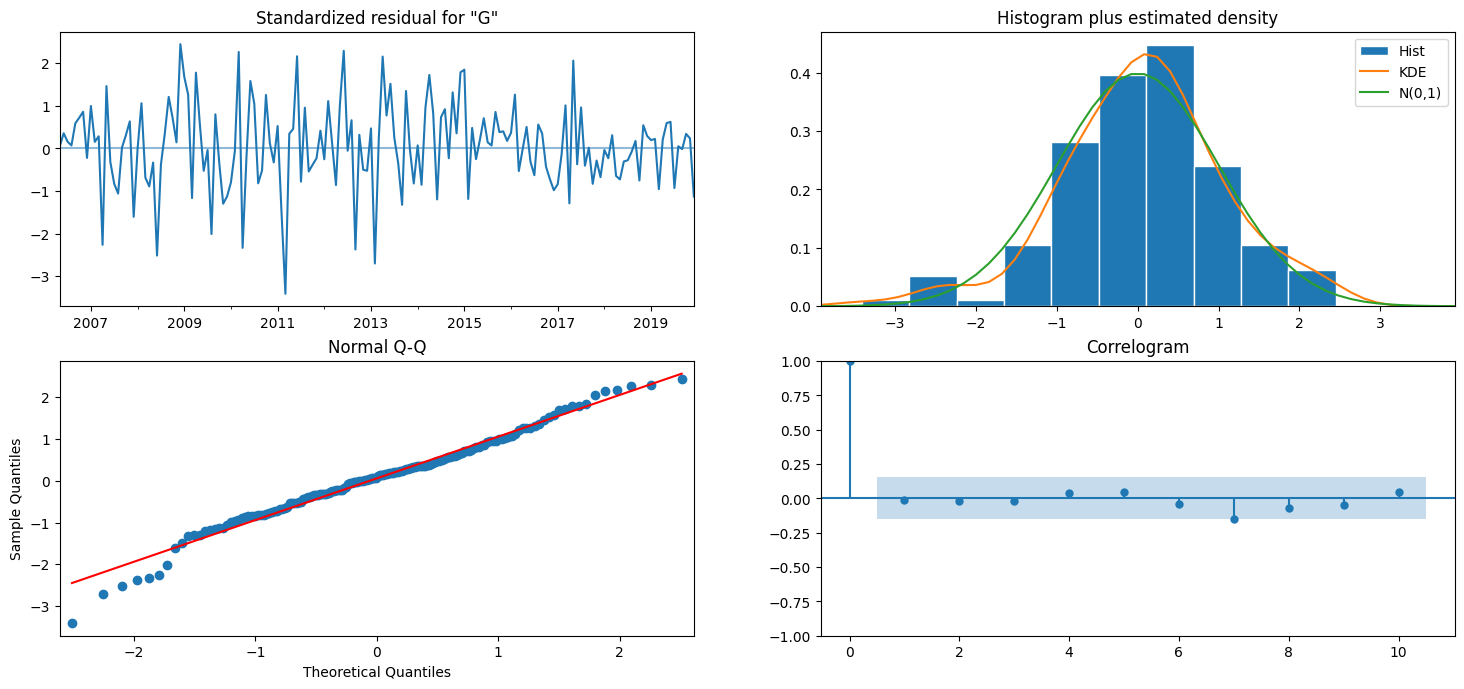

In [323]:
resultado_superior_221.plot_diagnostics(figsize=(18, 8))
plt.show()

In [324]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 121=",resultado_superior_121.aic)
print("Modelo 221=",resultado_superior_221.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 121=",resultado_superior_121.bic)
print("Modelo 221=",resultado_superior_221.bic)

Resultados de AIC (Akaike information criterion)
Modelo 121= -581.479255391467
Modelo 221= -580.5722728288563
Resultados de BIC (Bayesian information criterion)
Modelo 121= -556.6316916002623
Modelo 221= -552.6734749784385


De acuerdo a ambos indicadores es mejor el modelo p=1, d=2, q=1 por lo que este es el que será usado para predecir pues tinene un valor menor en AIC y en BIC

## Diesel

In [325]:
model_diesel_121 = SARIMAX(
  train_diesel_log,
  order=(1,2,1),
  seasonal_order=(3,1,0,12),
  enforce_stationarity=False,
  enforce_invertibility=False
)
resultado_diesel_121 = model_diesel_121.fit()
print(resultado_diesel_121.summary().tables[1])

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4097      0.065     -6.274      0.000      -0.538      -0.282
ma.L1         -1.0000    354.951     -0.003      0.998    -696.692     694.692
ar.S.L12      -0.6732      0.068     -9.925      0.000      -0.806      -0.540
ar.S.L24      -0.5365      0.078     -6.845      0.000      -0.690      -0.383
ar.S.L36      -0.2323      0.068     -3.435      0.001      -0.365      -0.100
sigma2         0.0045      1.586      0.003      0.998      -3.103       3.112


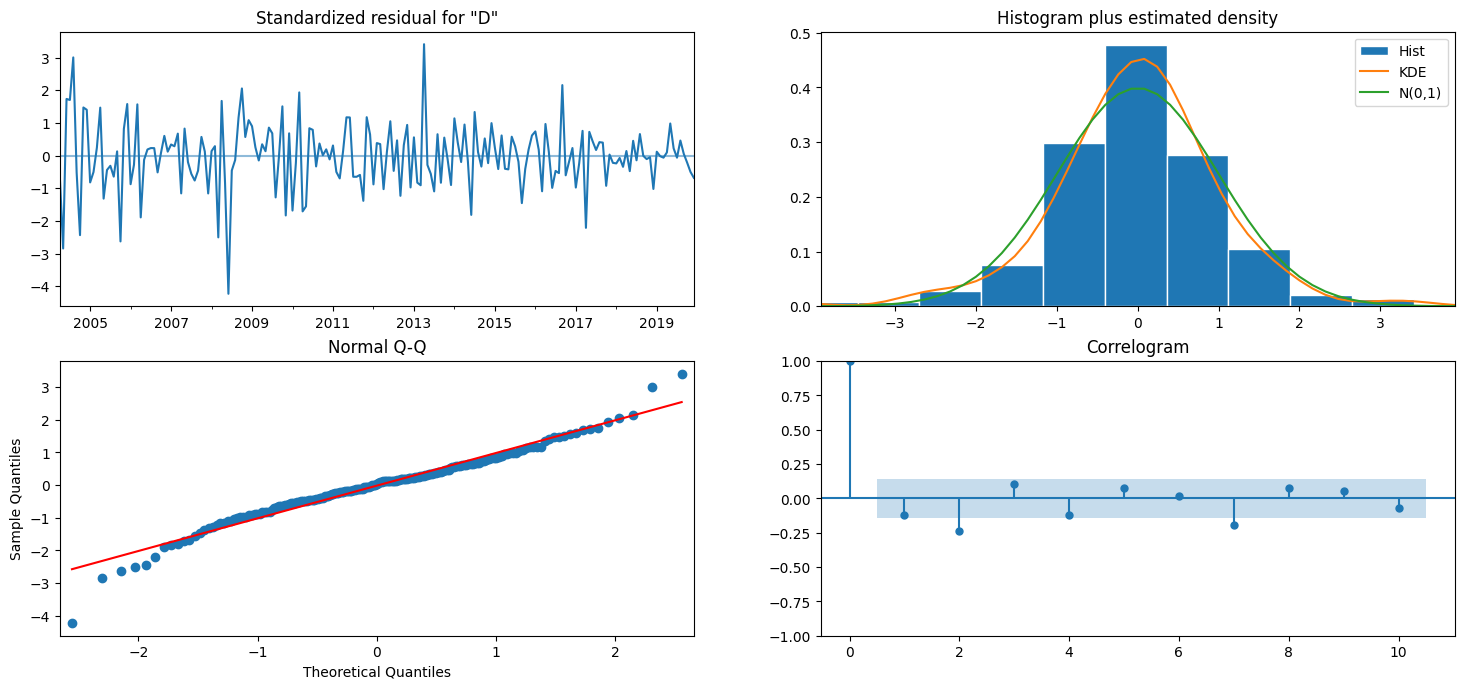

In [326]:
resultado_diesel_121.plot_diagnostics(figsize=(18, 8))
plt.show()

In [327]:
model_diesel_221 = SARIMAX(
  train_diesel_log,
  order=(2,2,1),
  seasonal_order=(3,1,0,12),
  enforce_stationarity=False,
  enforce_invertibility=False
)
resultado_diesel_221 = model_diesel_221.fit(disp=False)
print(resultado_diesel_221.summary().tables[1])

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5527      0.066     -8.312      0.000      -0.683      -0.422
ar.L2         -0.3156      0.040     -7.939      0.000      -0.394      -0.238
ma.L1         -1.0000    422.333     -0.002      0.998    -828.757     826.757
ar.S.L12      -0.7329      0.072    -10.122      0.000      -0.875      -0.591
ar.S.L24      -0.5336      0.084     -6.382      0.000      -0.698      -0.370
ar.S.L36      -0.2555      0.076     -3.379      0.001      -0.404      -0.107
sigma2         0.0040      1.701      0.002      0.998      -3.330       3.338


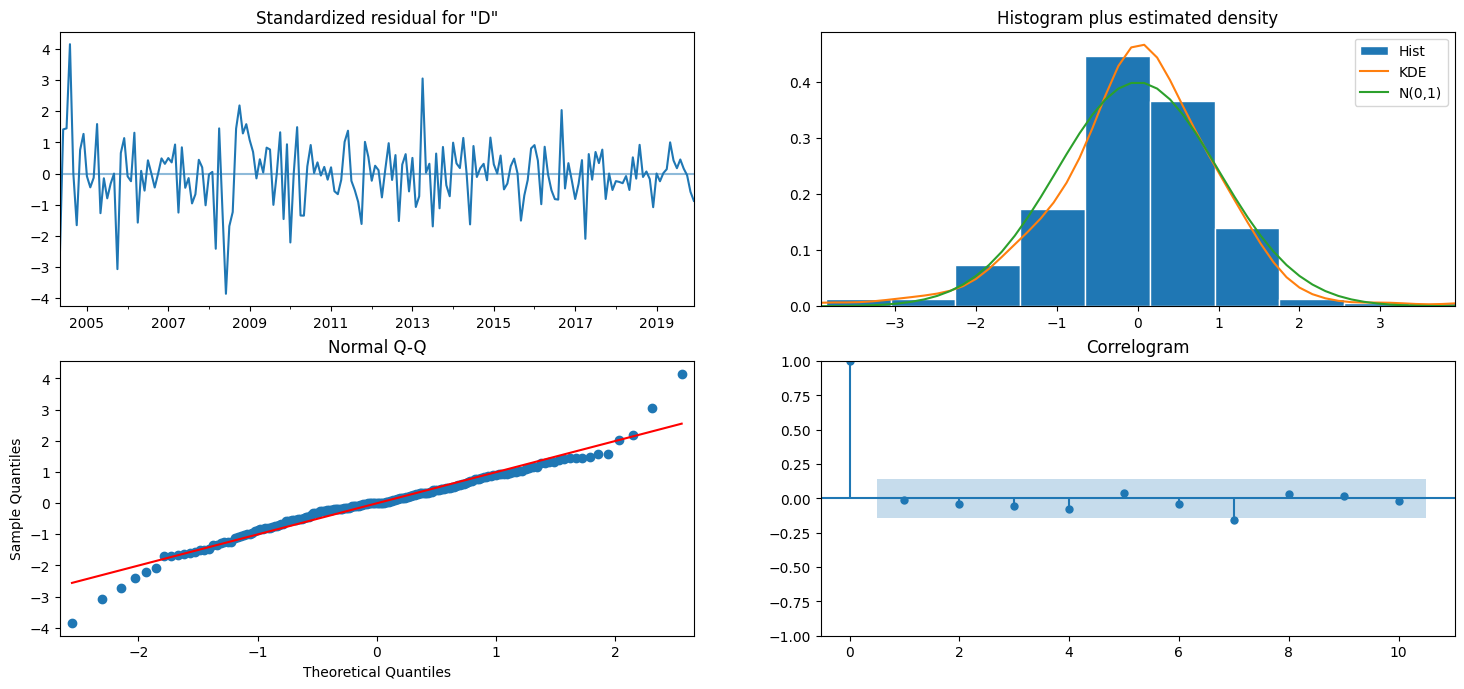

In [328]:
resultado_diesel_221.plot_diagnostics(figsize=(18, 8))
plt.show()

In [329]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 121=",resultado_diesel_121.aic)
print("Modelo 221=",resultado_diesel_221.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 121=",resultado_diesel_121.bic)
print("Modelo 221=",resultado_diesel_221.bic)

Resultados de AIC (Akaike information criterion)
Modelo 121= -469.4605813462831
Modelo 221= -484.4990474249945
Resultados de BIC (Bayesian information criterion)
Modelo 121= -450.01009925592524
Modelo 221= -461.84395368518483


De acuerdo a ambos indicadores es mejor el modelo p=2, d=2, q=1 por lo que este es el que será usado para predecir pues tinene un valor menor en AIC y en BIC

## Predicción con el mejor modelo

In [330]:
df_regular_indexed = df[['Fecha', label_regular]]
df_regular_indexed =  df_regular_indexed.set_index(['Fecha'])

In [331]:
df_superior_indexed = df[['Fecha', label_super]]
df_superior_indexed =  df_superior_indexed.set_index(['Fecha'])

In [332]:
df_diesel_indexed = df[['Fecha', label_diesel]]
df_diesel_indexed =  df_diesel_indexed.set_index(['Fecha'])

In [333]:
def checkModel(prediction, test_indexed, label):
  pred = prediction.get_prediction(
    start=test_indexed.index[0],
    end=test_indexed.index[-1],
  ).summary_frame(alpha=0.05)

  fig, ax = plt.subplots(figsize=(15,5))
  test_log = np.log(test_indexed[label])
  ax = test_log.plot(label='Test Data')
  ax.set(
      title='True and Predicted Values, with Confidence Intervals',
      xlabel='Date',
      ylabel='Actual / Predicted Values'
  )

  pred['mean'].plot(ax=ax, style='r', label='Predicted Mean')
  ax.fill_between(
      pred.index, pred['mean_ci_lower'], pred['mean_ci_upper'],
      color='r', alpha=0.1
  )
  legend = ax.legend(loc='upper left')
  plt.show()

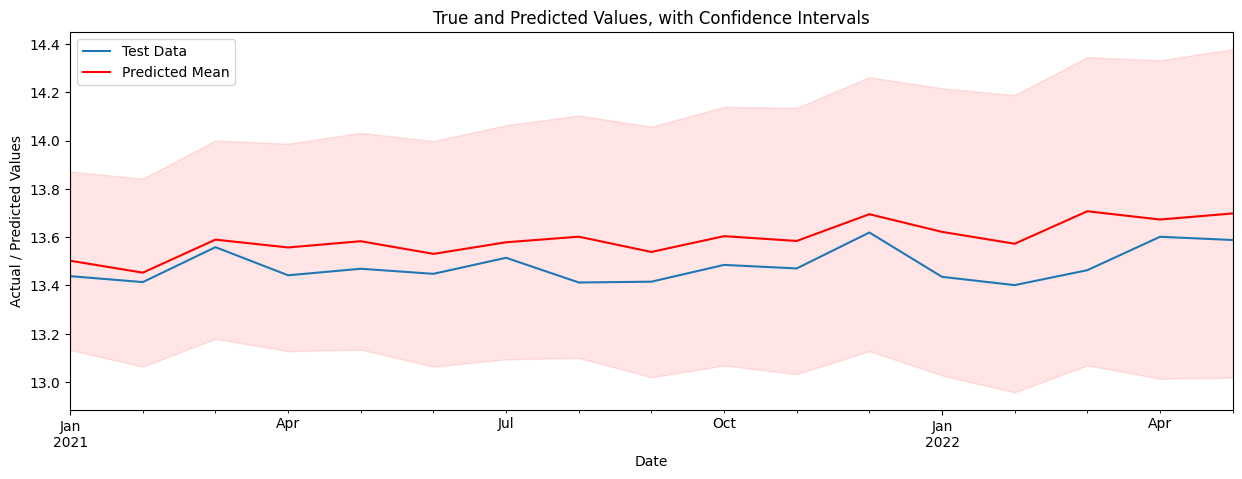

In [335]:
checkModel(resultado_regular_121, test_regular_indexed, label_regular)

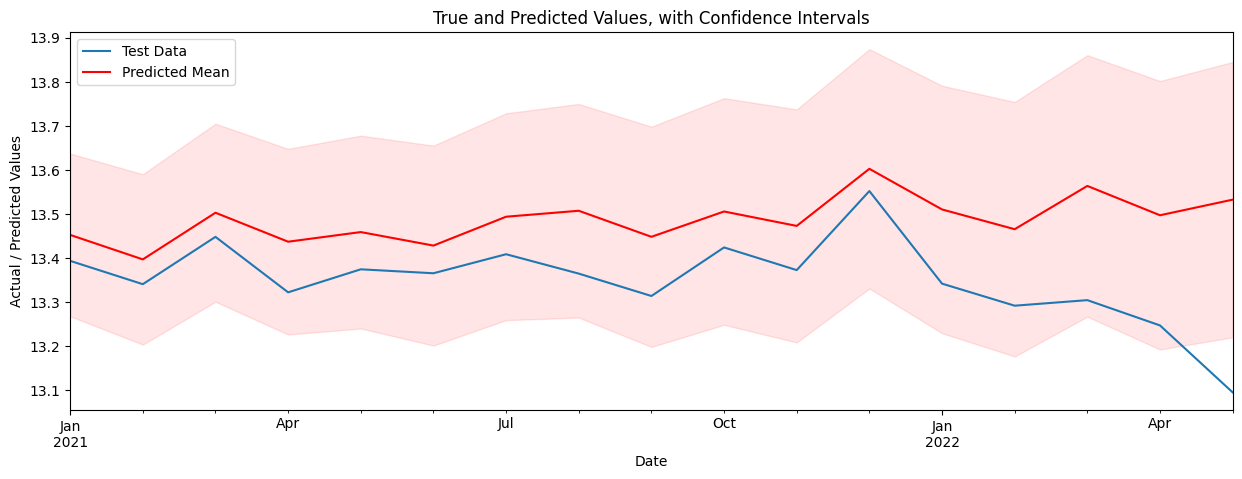

In [336]:
checkModel(resultado_superior_221, test_superior_indexed, label_super)

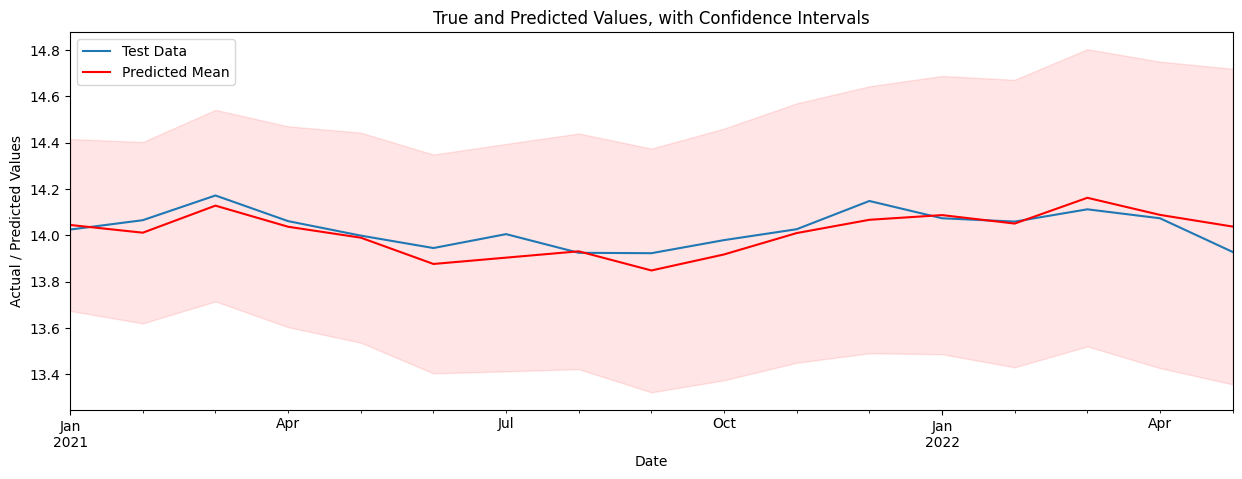

In [340]:
checkModel(resultado_diesel_121, test_diesel_indexed, label_diesel)